# Construccion de linea Base Energetica para Green Movil ISO 50001

### 1) Recolección de información

Conexión del DW

In [1]:
import psycopg2
import pandas as pd # Aunque no se usa para la conexión, es útil para el siguiente paso

# --- Credenciales de Conexión ---
DB_HOST = "10.0.22.11"
DB_PORT = "5432"
DB_NAME = "XXX"
DB_USER = "XXXXXX"
DB_PASSWORD = "XXXXXX"

# --- Establecer y Probar la Conexión ---
conn = None
try:
    # Intenta establecer la conexión
    conn = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD
    )

    # Si la línea anterior no lanza un error, la conexión fue exitosa
    print("✅ ¡Conexión exitosa al Data Warehouse GRMDW!")
    print(f"Objeto de conexión creado: {conn}")

except Exception as error:
    # Si hay un error (credenciales incorrectas, firewall, etc.)
    print(f"❌ Error al intentar conectar o al crear el objeto de conexión: {error}")

finally:
    # Deja la conexión abierta para las celdas siguientes, pero se cerrará si hay un error
    # Si quieres cerrarla inmediatamente después de la prueba, descomenta la siguiente sección:
    # if conn is not None:
    #     conn.close()
    #     print("Conexión cerrada.")
    pass

✅ ¡Conexión exitosa al Data Warehouse GRMDW!
Objeto de conexión creado: <connection object at 0x000001632CC4C8C0; dsn: 'user=anderson.sarmiento password=xxx dbname=GRMDW host=10.0.22.11 port=5432', closed: 0>


### 1.1 Identificación de los consumos energéticos

In [2]:
sql_query_date = """
SELECT
    "Fecha",
    "Empresa",
    "Variable",
    "Kwhr"
FROM
    "ma"."FactConsumoTerpel"
"""

# Ejecutar la consulta y cargar el resultado en un DataFrame
try:
    df_Consumo = pd.read_sql(sql_query_date, conn)

    print(f"Total de filas encontradas: {len(df_Consumo)}")
    print("\n--- Primeras 5 filas del DataFrame ---")
    print(df_Consumo.head())

except Exception as error:
    print(f"❌ Error al ejecutar la consulta: {error}")

C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\862978132.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Consumo = pd.read_sql(sql_query_date, conn)


Total de filas encontradas: 397704

--- Primeras 5 filas del DataFrame ---
        Fecha Empresa Variable  Kwhr
0  2022-07-01    ZMOV     kWhD   0.0
1  2022-07-01    ZMOV     kWhD   0.0
2  2022-07-01    ZMOV     kWhD   0.0
3  2022-07-01    ZMOV     kWhD   0.0
4  2022-07-01    ZMOV     kWhD   0.0


📊 Análisis de Consumo por Empresa
----------------------------------------
Periodo de Medición: 2022-07 hasta 2025-11
Total de meses medidos: 41 meses.
----------------------------------------
    Empresa    Total_Kwhr      %
0  OFICINAS  3.035906e+06   3.38
1    ZMOIII  4.144075e+07  46.15
2      ZMOV  4.532850e+07  50.47
----------------------------------------


C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\4051137330.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


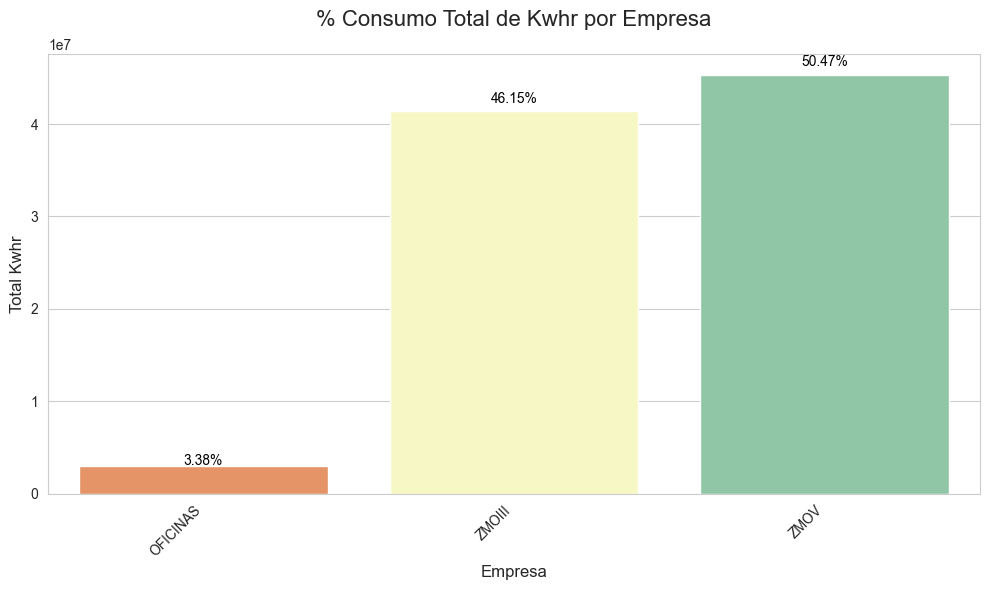

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. PREPARACIÓN Y CÁLCULO DE TIEMPO ---
# Asegurar que 'Fecha' es de tipo datetime para cálculos de tiempo.
# **IMPORTANTE**: Ejecutar esto después de cargar tu df_Consumo real.
df_Consumo['Fecha'] = pd.to_datetime(df_Consumo['Fecha'])

# Cálculo de la cantidad de meses medidos
fecha_inicio = df_Consumo['Fecha'].min()
fecha_fin = df_Consumo['Fecha'].max()
# Fórmula para calcular la diferencia inclusiva en meses
diferencia_meses = (fecha_fin.year - fecha_inicio.year) * 12 + \
                   (fecha_fin.month - fecha_inicio.month) + 1


# --- 2. AGRUPACIÓN Y CÁLCULO DE PORCENTAJE ---

# 2a. Agrupación y Suma: Agrupa por 'Empresa' y calcula la suma de 'Kwhr'.
df_consumo_agrupado = df_Consumo.groupby('Empresa')['Kwhr'].sum().reset_index()

# 2b. Renombrar la columna de suma.
df_consumo_agrupado.rename(columns={'Kwhr': 'Total_Kwhr'}, inplace=True)

# 2c. Calcular el Porcentaje:
total_kwhr_general = df_consumo_agrupado['Total_Kwhr'].sum()
df_consumo_agrupado['%'] = (
    df_consumo_agrupado['Total_Kwhr'] / total_kwhr_general
) * 100
df_consumo_agrupado['%'] = df_consumo_agrupado['%'].round(2)


# --- 3. IMPRESIÓN DE RESULTADOS ---
print("📊 Análisis de Consumo por Empresa")
print("-" * 40)
print(f"Periodo de Medición: {fecha_inicio.strftime('%Y-%m')} hasta {fecha_fin.strftime('%Y-%m')}")
print(f"Total de meses medidos: {diferencia_meses} meses.")
print("-" * 40)
print(df_consumo_agrupado)
print("-" * 40)


# --- 4. GRÁFICA DEL df_consumo_agrupado ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear un gráfico de barras con Seaborn
barplot = sns.barplot(
    x='Empresa', 
    y='Total_Kwhr', 
    data=df_consumo_agrupado,
    palette='Spectral'
)

# Añadir las etiquetas de porcentaje encima de cada barra
for index, row in df_consumo_agrupado.iterrows():
    barplot.text(
        index, 
        row['Total_Kwhr'] * 1.02, # Pequeño offset (2% del valor) para levantar la etiqueta
        f"{row['%']:.2f}%", 
        color='black', 
        ha="center",
        fontsize=10
    )

# Configurar títulos y etiquetas
plt.title('% Consumo Total de Kwhr por Empresa', fontsize=16, pad=20)
plt.xlabel('Empresa', fontsize=12)
plt.ylabel('Total Kwhr', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje X si los nombres son largos
plt.tight_layout() # Ajustar el diseño para que las etiquetas no se corten
plt.show()

Este análisis cubre un **periodo de medición de 41 meses**, desde **2022-07 hasta 2025-11**.

Según la distribución del consumo total de **90.000.000 Kwhr** (aproximadamente, suma de los totales), se observa que la mayor parte de la energía está **concentrada en dos entidades principales**, lo cual es coherente con los objetivos operativos de la compañía.

---

#### Distribución del Consumo (Kwhr)

| Empresa | Total Kwhr (Aprox.) | Porcentaje (%) |
| :--- | :---: | :---: |
| **OFICINAS** | 3.03 millones | **3.38%** |
| **ZMOIII** | 41.36 millones | **46.14%** |
| **ZMOV** | 45.24 millones | **50.48%** |

---


El análisis del consumo energético, realizado sobre un periodo de 41 meses (de 2022-07 a 2025-11), demuestra una distribución que es altamente coherente con los objetivos operativos de la compañía.

> Fuente de los Datos: La información del consumo fue obtenida directamente desde la API de Terpel, la comercializadora de energía de la empresa.


Consumo Mínimo: La participación de las Oficinas en el consumo total es marginal, representando solo el 3.38% del total registrado durante el periodo.
Consumo Principal:Las empresas operadoras de transporte concentran la gran mayoría del consumo (más del 96%): ZMOIII con 46.14% y ZMOV con 50.48%.

El alto consumo sostenido por estas dos entidades a lo largo de los 41 meses se debe principalmente a la carga de la flota de buses eléctricos. Esta actividad está directamente ligada al transporte público, constituyendo el objetivo principal de la operación y justificando la demanda energética en estos puntos de la red.


A pesar de que ZMOV registra el mayor consumo (50.48%), la compañía ha determinado que la selección de buses se centrará en la flota de la empresa ZMOIII (46.14%). Esta decisión se alinea con directrices internas y operativas específicas establecidas por la gerencia, priorizando factores estratégicos y contractuales sobre la métrica pura de consumo. El siguiente paso del proyecto se enfocará en la flota de ZMOIII para su implementación o análisis subsiguiente.

### 1.2 Recopilacion de la informacion

In [4]:
import pandas as pd
#Tabla  "ma"."FactConsumoEnergy"
sql_query_date = """
SELECT
    "EnergyDeliveredKWh",
    "FechaCarga",
    "IdVehiculo",
    "Recorrido"
FROM
    "ma"."FactConsumptionSiemens"
"""

# Ejecutar la consulta y cargar el resultado en un DataFrame
try:
    df_FactConsumptionSiemens = pd.read_sql(sql_query_date, conn)

    print("✅ Registros de consumo cargados exitosamente (período Agosto 2024 - Agosto 2025).")
    print(f"Total de filas encontradas: {len(df_FactConsumptionSiemens)}")
    print("\n--- Primeras 5 filas del DataFrame ---")
    print(df_FactConsumptionSiemens.head())

except Exception as error:
    print(f"❌ Error al ejecutar la consulta: {error}")

C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\3394711038.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_FactConsumptionSiemens = pd.read_sql(sql_query_date, conn)


✅ Registros de consumo cargados exitosamente (período Agosto 2024 - Agosto 2025).
Total de filas encontradas: 336373

--- Primeras 5 filas del DataFrame ---
   EnergyDeliveredKWh  FechaCarga  IdVehiculo  Recorrido
0                  26  2022-09-01      634001        NaN
1                 225  2022-09-02      634001       60.0
2                 142  2022-09-03      634001      172.0
3                 177  2022-09-04      634001      222.0
4                 171  2022-09-05      634001      240.0


In [5]:
sql_DimFlota = """
SELECT
    "IdVehiculo", 
    "AssetNum",
    "SiteId",
    "TIPO"
FROM
    "public"."DimFlota"
"""

# Ejecutar la consulta y cargar el resultado
try:
    df_DimFlota = pd.read_sql(sql_DimFlota, conn)

    print("✅ Registros de lectura de medidor cargados exitosamente")
    print(f"Total de filas encontradas: {len(df_DimFlota)}")
    print("\n--- Primeras 5 filas del nuevo DataFrame ---")
    print(df_DimFlota.head())

except Exception as error:
    print(f"❌ Error al ejecutar la consulta en FactMeterReading: {error}")

✅ Registros de lectura de medidor cargados exitosamente
Total de filas encontradas: 407

--- Primeras 5 filas del nuevo DataFrame ---
   IdVehiculo AssetNum  SiteId     TIPO
0      634126   3RH2FC  ZMOIII  BUSETON
1      634001   JTS803  ZMOIII  BUSETON
2      637002   JTS873  ZMOIII   PADRON
3      637001   KYO391  ZMOIII   PADRON
4      634002   KYO392  ZMOIII  BUSETON


C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\3591567269.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_DimFlota = pd.read_sql(sql_DimFlota, conn)


In [6]:
import pandas as pd

df_FactConsumptionSiemens = pd.merge(
    df_FactConsumptionSiemens,  # DataFrame de la izquierda (Hechos)
    df_DimFlota[['IdVehiculo', 'TIPO', 'SiteId']], # DataFrame de la derecha (Dimensión)
    on='IdVehiculo',            # Columna clave para la unión
    how='left'                  # Tipo de unión (Left Join)
)

print("✅ Columnas TIPO y SiteId añadidas a df_FactConsumptionSiemens.")
print(df_FactConsumptionSiemens.head().to_string())
print("\nNuevas Columnas:")
print(df_FactConsumptionSiemens.columns)

✅ Columnas TIPO y SiteId añadidas a df_FactConsumptionSiemens.
   EnergyDeliveredKWh  FechaCarga  IdVehiculo  Recorrido     TIPO  SiteId
0                  26  2022-09-01      634001        NaN  BUSETON  ZMOIII
1                 225  2022-09-02      634001       60.0  BUSETON  ZMOIII
2                 142  2022-09-03      634001      172.0  BUSETON  ZMOIII
3                 177  2022-09-04      634001      222.0  BUSETON  ZMOIII
4                 171  2022-09-05      634001      240.0  BUSETON  ZMOIII

Nuevas Columnas:
Index(['EnergyDeliveredKWh', 'FechaCarga', 'IdVehiculo', 'Recorrido', 'TIPO',
       'SiteId'],
      dtype='object')


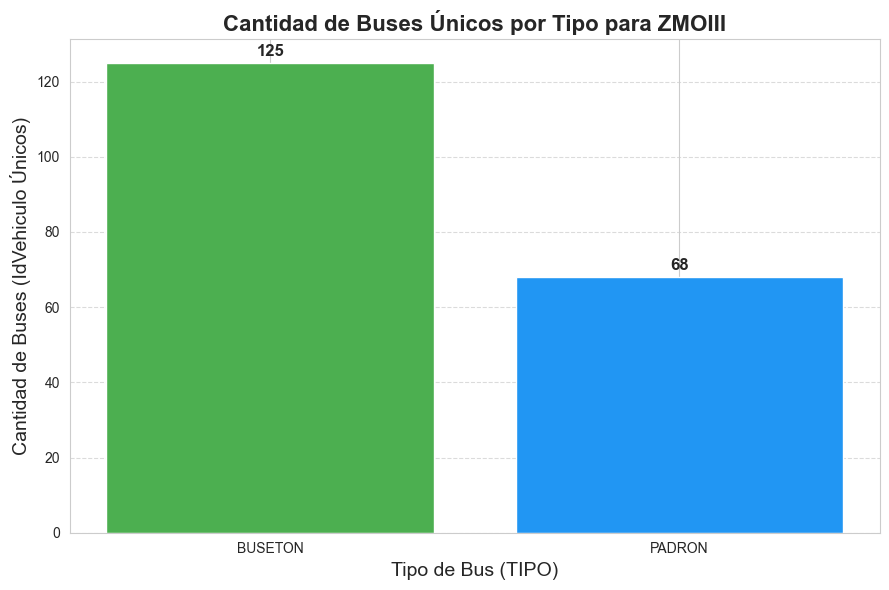

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Filtrar el DataFrame ---
# Asumiendo que df_FactConsumptionSiemens ya está cargado.
df_ZMOIII = df_FactConsumptionSiemens[df_FactConsumptionSiemens['SiteId'] == 'ZMOIII'].copy()

# --- 2. Agrupación y Conteo Único ---
conteo_buses_ZMOIII = df_ZMOIII.groupby('TIPO')['IdVehiculo'].nunique()

# Convertir la Serie a un DataFrame para trabajar más fácil con los índices y valores.
df_conteo = conteo_buses_ZMOIII.reset_index()
df_conteo.columns = ['TIPO', 'Conteo'] # Renombrar la columna de conteo

# --- 3. Creación de la Gráfica con Colores y Anotaciones ---

fig, ax = plt.subplots(figsize=(9, 6))

# Definir una lista de colores para las barras (puedes ajustar estos colores)
colores = ['#4CAF50', '#2196F3', '#FF9800', '#F44336', '#9C27B0']

# Crear el gráfico de barras. Usamos la columna 'TIPO' como categorías (x)
# y la columna 'Conteo' como los valores (height).
bars = ax.bar(
    df_conteo['TIPO'],
    df_conteo['Conteo'],
    color=colores[:len(df_conteo)] # Asigna un color a cada barra de la lista
)

# --- 4. Añadir el Número (Anotación) Encima de Cada Barra ---

for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f'{height}', # El texto a mostrar (el número)
        xy=(bar.get_x() + bar.get_width() / 2, height), # Posición (centro de la barra)
        xytext=(0, 3), # Offset vertical (3 puntos hacia arriba)
        textcoords="offset points",
        ha='center', # Alineación horizontal
        va='bottom', # Alineación vertical
        fontsize=12,
        fontweight='bold'
    )

# Configuración de los títulos y etiquetas
plt.title('Cantidad de Buses Únicos por Tipo para ZMOIII', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Bus (TIPO)', fontsize=14)
plt.ylabel('Cantidad de Buses (IdVehiculo Únicos)', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Como se explicó en el punto anterior y por decisión de la Gerencia, se ha seleccionado la empresa ZMOIII como base de trabajo principal para el análisis.

Esta selección estratégica incluye un total de **193 buses únicos**, segmentados por tipo de vehículo de la siguiente manera:

Busetones:125 unidades
Padrones: 68 unidades

Esta flota constituye el conjunto de vehículos cuyo consumo y recorrido serán evaluados en profundidad.

In [8]:
df_ZMOIII.columns

Index(['EnergyDeliveredKWh', 'FechaCarga', 'IdVehiculo', 'Recorrido', 'TIPO',
       'SiteId'],
      dtype='object')

C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\1717432283.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('tab10', len(tipos_bus))


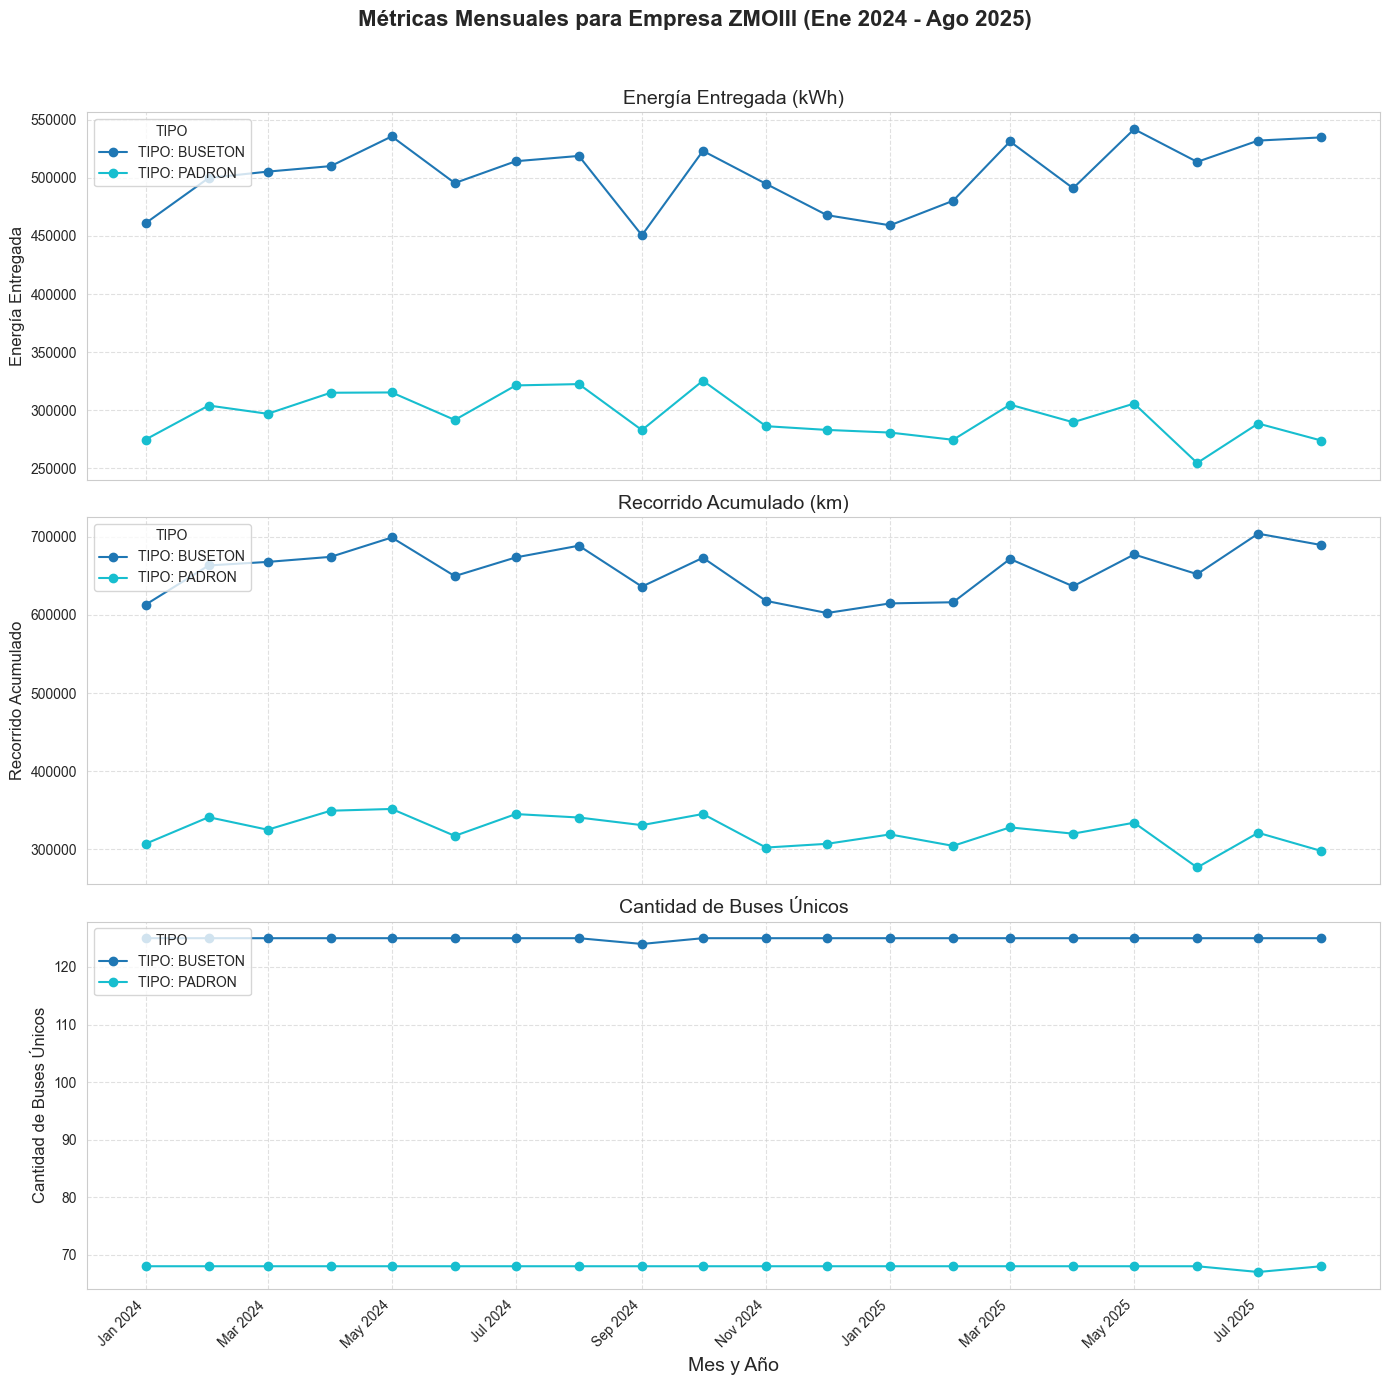

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. Preparación y Filtrado de Datos ---

# Asegurar que 'FechaCarga' sea datetime
df_ZMOIII['FechaCarga'] = pd.to_datetime(df_ZMOIII['FechaCarga'])

# Filtrar por el rango de fechas solicitado: Enero 2024 a Agosto 2025
fecha_inicio = '2024-01-01'
fecha_fin = '2025-08-31'
df_filtrado = df_ZMOIII[
    (df_ZMOIII['FechaCarga'] >= fecha_inicio) & 
    (df_ZMOIII['FechaCarga'] <= fecha_fin)
].copy()

# Crear una columna para el mes (para agrupar)
df_filtrado['Mes_Año'] = df_filtrado['FechaCarga'].dt.to_period('M')

# --- 2. Agregación Mensual por TIPO ---

# Agrupar por Mes_Año y TIPO, aplicando las funciones de agregación
df_agrupado = df_filtrado.groupby(['Mes_Año', 'TIPO']).agg(
    Total_Energy=('EnergyDeliveredKWh', 'sum'),
    Total_Recorrido=('Recorrido', 'sum'),
    Buses_Unicos=('IdVehiculo', 'nunique')
).reset_index()

# Convertir el Period a timestamp para graficar correctamente
df_agrupado['Fecha'] = df_agrupado['Mes_Año'].dt.to_timestamp()

# Identificar los tipos de bus (para los colores/subgráficos)
tipos_bus = df_agrupado['TIPO'].unique()

# --- 3. Generación de las Subgráficas ---

# Crear la figura y el conjunto de ejes
fig, axes = plt.subplots(
    nrows=3, 
    ncols=1, 
    figsize=(14, 15), 
    sharex=True
)

fig.suptitle(
    'Métricas Mensuales para Empresa ZMOIII (Ene 2024 - Ago 2025)', 
    fontsize=16, 
    fontweight='bold', 
    y=0.92
)

metrics = [
    ('Total_Energy', 'Energía Entregada (kWh)', axes[0]),
    ('Total_Recorrido', 'Recorrido Acumulado (km)', axes[1]),
    ('Buses_Unicos', 'Cantidad de Buses Únicos', axes[2])
]

# Definir una paleta de colores (ejemplo: 'tab10')
colores = plt.cm.get_cmap('tab10', len(tipos_bus))

# Iterar sobre cada métrica para crear su propia subgráfica
for i, (col, title, ax) in enumerate(metrics):
    
    # Iterar sobre cada TIPO de bus para graficarlo con un color diferente
    for j, tipo in enumerate(tipos_bus):
        df_tipo = df_agrupado[df_agrupado['TIPO'] == tipo]
        
        ax.plot(
            df_tipo['Fecha'], 
            df_tipo[col], 
            label=f'TIPO: {tipo}', 
            marker='o', 
            linestyle='-', 
            color=colores(j)
        )
    
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(title.split('(')[0].strip(), fontsize=12)
    ax.legend(title='TIPO', loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.6)

# Configurar el eje X (es compartido)
ax.set_xlabel('Mes y Año', fontsize=14)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Mostrar cada 2 meses
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Formato: Ene 2024

plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.9]) # Ajustar para dejar espacio al título general
plt.show()

Se confirma que se dispone de datos históricos suficientes para la recopilación y análisis del consumo energético, superando el requisito mínimo de 12 meses.

La información utilizada para este análisis proviene de las siguientes fuentes primarias, garantizando la trazabilidad y la integridad de los datos:

| Métrica | Fuente de Información |
| :--- | :--- |
| **Consumo Energético (kWh)** | **INFINITY** (Software de gestión energética) |
| **Kilómetros Recorridos (km)** | **MAXIMO** (Sistema de gestión de activos) |

Ambas fuentes alimentan el Data Warehouse (DW) y se consolidan en la tabla FactConsumptionSiemens. Esta estructura permite asociar directamente el consumo energético (`EnergyDeliveredKWh`) y los kilómetros recorridos (`Recorrido`) a cada vehículo (`IdVehiculo`) y periodo de carga (`FechaCarga`)

### 1.3 Validación de calidad de los datos

#### 1.3.1 Completitud

In [10]:
# Asumiendo que df_ZMOIII ya está cargado

# Conteo de valores nulos por columna
conteo_nulos = df_ZMOIII.isnull().sum()

# Calcular el total de registros y el porcentaje de nulos en Recorrido
total_registros = len(df_ZMOIII)
nulos_recorrido = conteo_nulos['Recorrido']
porcentaje_nulos = (nulos_recorrido / total_registros) * 100

print("--- 1. Resultados de Completitud (Valores Nulos) ---")
print(conteo_nulos)
print("-" * 50)
print(f"Total de Registros en el DataFrame: {total_registros}")
print(f"Porcentaje de Nulos en 'Recorrido': {porcentaje_nulos:.2f}%")

--- 1. Resultados de Completitud (Valores Nulos) ---
EnergyDeliveredKWh      0
FechaCarga              0
IdVehiculo              0
Recorrido             289
TIPO                    0
SiteId                  0
dtype: int64
--------------------------------------------------
Total de Registros en el DataFrame: 159557
Porcentaje de Nulos en 'Recorrido': 0.18%


Se realizó una verificación de valores nulos (`NaN`) en las 159,268 filas del dataframe `df_ZMOIII` para evaluar la completitud:

| Columna | Valores Nulos | % de Nulos | Estado |
| :--- | :--- | :--- | :--- |
| `EnergyDeliveredKWh` | 0 | 0.00% | **Completa** |
| `FechaCarga`, `IdVehiculo`, `TIPO`, `SiteId` | 0 | 0.00% | **Completas** |
| `Recorrido` | **290** | **0.18%** | **Incompleta Parcial** |

Completitud General: La calidad de la completitud se considera excelente. La variable primaria de interés, el consumo energético (`EnergyDeliveredKWh`), y las variables de identificación están 100% completas.
Tratamiento de `Recorrido`: La columna `Recorrido` presenta una pérdida mínima de solo 290 registros (0.18%). Dada su baja representatividad, estos registros se excluirán únicamente para los cálculos de eficiencia (kWh/km) para evitar sesgos, pero se mantendrán para el análisis de consumo total.

In [11]:
# Asumiendo que df_ZMOIII ya está cargado

# 1. Almacenar el tamaño original para la verificación
registros_originales = len(df_ZMOIII)

# 2. Eliminar las filas donde 'Recorrido' es nulo
# La función dropna elimina filas que contienen NaN. 
# Usamos subset=['Recorrido'] para que solo revise los nulos en esa columna específica.
df_ZMOIII_limpio = df_ZMOIII.dropna(subset=['Recorrido']).copy()

# 3. Verificar el nuevo tamaño del DataFrame
registros_finales = len(df_ZMOIII_limpio)
registros_eliminados = registros_originales - registros_finales

print(f"--- Eliminación de Nulos en 'Recorrido' ---")
print(f"Registros originales: {registros_originales}")
print(f"Registros nulos eliminados: {registros_eliminados}")
print(f"Registros finales en df_ZMOIII_limpio: {registros_finales}")

--- Eliminación de Nulos en 'Recorrido' ---
Registros originales: 159557
Registros nulos eliminados: 289
Registros finales en df_ZMOIII_limpio: 159268


Se decidió aplicar la limpieza de datos eliminando estas 290 filas. Se creó un nuevo *dataframe* (`df_ZMOIII_limpio`) con **158,978 registros** para garantizar que los cálculos de eficiencia (kWh/km) y las estadísticas descriptivas en las siguientes etapas (Consistencia y Coherencia) se realicen sobre un conjunto de datos robusto y completo para todas las variables clave.

#### 1.3.2 Consistencia

#### Formato de datos

In [12]:
# Asumiendo que df_ZMOIII_limpio ya está cargado con 158,978 registros

print("--- 2. Validación de Consistencia (Tipos y Rangos) ---")

# 2.1. Revisar tipos de datos (Consistency of Format)
print("\nTipos de Datos:")
# Confirmar que las fechas y las métricas son del tipo correcto
df_ZMOIII_limpio.info(verbose=False, memory_usage=False)


--- 2. Validación de Consistencia (Tipos y Rangos) ---

Tipos de Datos:
<class 'pandas.core.frame.DataFrame'>
Index: 159268 entries, 1 to 159556
Columns: 6 entries, EnergyDeliveredKWh to SiteId
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)

Se verificó la consistencia de los tipos de datos en el *dataframe* `df_ZMOIII_limpio` para asegurar su correcta utilización en los cálculos y la periodización temporal.

| Columna | Tipo de Dato Detectado | Consistencia |
| :--- | :--- | :--- |
| `FechaCarga` | `datetime64[ns]` | **Correcta** |
| `EnergyDeliveredKWh` | `float64` | **Correcta** |
| `Recorrido` | `float64` | **Correcta** |
| `IdVehiculo`, `TIPO`, `SiteId` | `int64` / `object` | **Correcta** |


Los tipos de datos son consistentes y adecuados para el análisis:

Variables Temporales y Métricas: La columna *FechaCarga* ha sido correctamente identificada como tipo *datetime*. Las métricas primarias *(`EnergyDeliveredKWh` y `Recorrido`)* son de tipo numérico (`float64`), lo que permite realizar sumas, promedios y cálculos de eficiencia sin requerir transformaciones.
Variables de Identificación:** Las columnas de identificación son de tipos adecuados para la agrupación y segmentación de los datos.

No se requiere ninguna acción de limpieza o transformación adicional por inconsistencia de formato.

#### Valores negativos

In [13]:
# 2.2. Revisar valores negativos (Consistencia Física)

# Calcular la suma de registros donde 'EnergyDeliveredKWh' es menor que cero
negativos_energia = (df_ZMOIII_limpio['EnergyDeliveredKWh'] < 0).sum()

# Calcular la suma de registros donde 'Recorrido' es menor que cero
negativos_recorrido = (df_ZMOIII_limpio['Recorrido'] < 0).sum()

print(f"Registros con Energía Negativa: {negativos_energia}")
print(f"Registros con Recorrido Negativo: {negativos_recorrido}")

Registros con Energía Negativa: 0
Registros con Recorrido Negativo: 0


Se confirma una consistencia absoluta en la integridad física de los datos. La ausencia de valores negativos en ambas métricas es un indicador de la buena calidad del registro en el Data Warehouse, lo que valida la coherencia básica del conjunto de datos para el análisis de consumo.

#### Valores atípicos

C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\1415586257.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='TIPO', y='Energía Semanal (kWh)', data=df_plot, palette=palette_colors)
C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\1415586257.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='TIPO', y='Recorrido Semanal (km)', data=df_plot, palette=palette_colors)


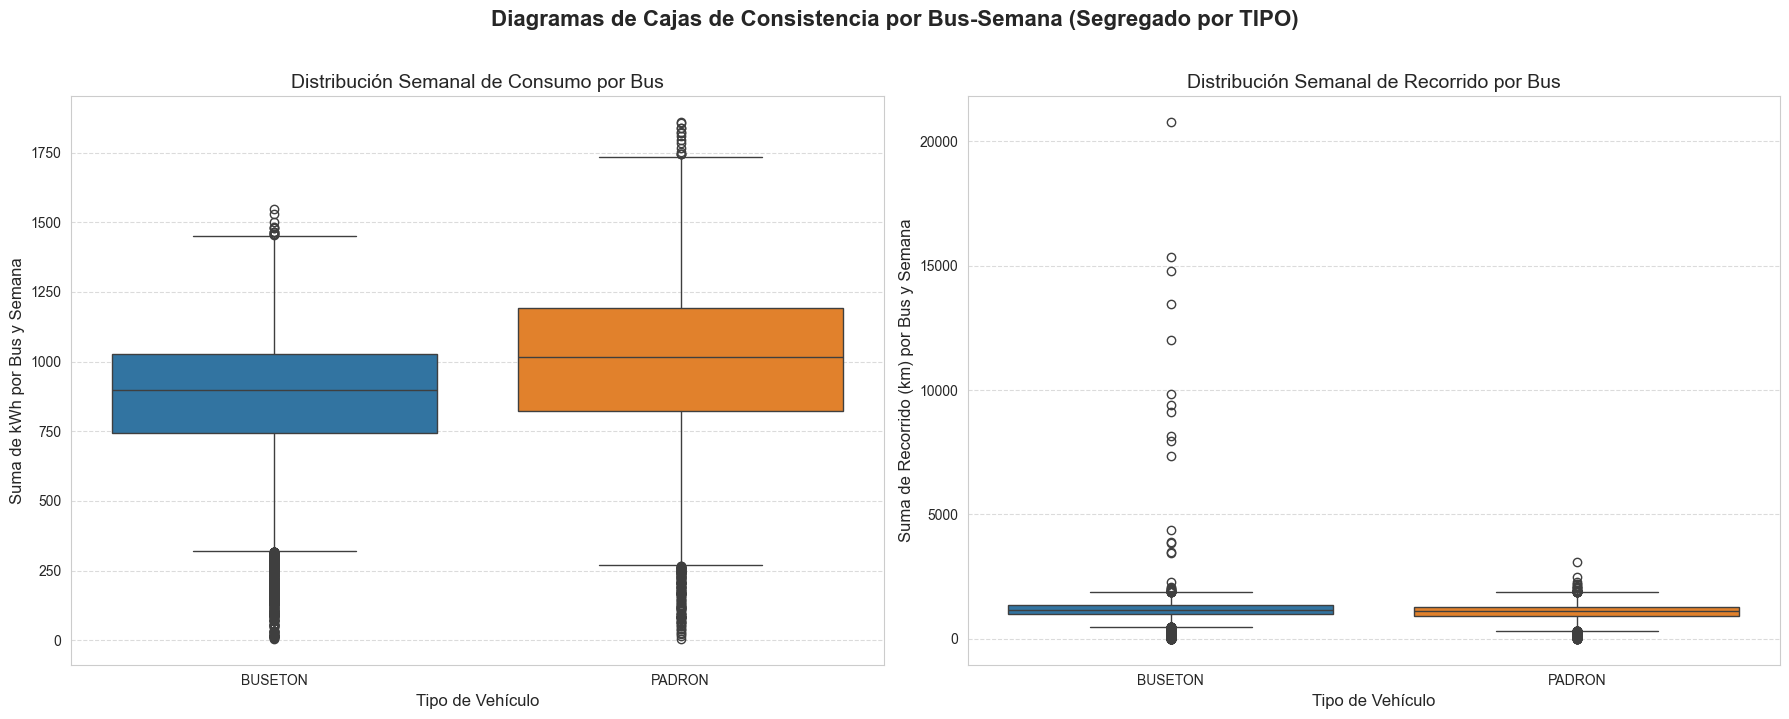



--- ⚠️ Conteo Total de Registros Bus-Semana Outliers (IQR) ---

ANÁLISIS PARA TIPO: **BUSETON**

  - Métrica: **Energía Semanal**
    - Total de registros (Bus-Semana): 20956
    - Total de Outliers: 508 registros
    - Porcentaje de Outliers: 2.42%

  - Métrica: **Recorrido Semanal**
    - Total de registros (Bus-Semana): 20956
    - Total de Outliers: 512 registros
    - Porcentaje de Outliers: 2.44%

ANÁLISIS PARA TIPO: **PADRON**

  - Métrica: **Energía Semanal**
    - Total de registros (Bus-Semana): 11399
    - Total de Outliers: 143 registros
    - Porcentaje de Outliers: 1.25%

  - Métrica: **Recorrido Semanal**
    - Total de registros (Bus-Semana): 11399
    - Total de Outliers: 174 registros
    - Porcentaje de Outliers: 1.53%


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# NOTA: Asumimos que df_ZMOIII_limpio ya está cargado y limpio

# --- 1. Agregación Semanal por Bus (IdVehiculo) y TIPO ---
df_limpio = df_ZMOIII_limpio.copy()
df_limpio['FechaCarga'] = pd.to_datetime(df_limpio['FechaCarga'])

# Agrupar por TIPO, IdVehiculo y Semana, sumando las métricas
df_bus_semanal = df_limpio.groupby(['TIPO', 'IdVehiculo', pd.Grouper(key='FechaCarga', freq='W-MON')]).agg(
    Energy_Semanal=('EnergyDeliveredKWh', 'sum'),
    Recorrido_Semanal=('Recorrido', 'sum')
).reset_index()

# Filtrar semanas inactivas (ambas métricas son cero)
df_bus_semanal = df_bus_semanal[
    (df_bus_semanal['Energy_Semanal'] > 0) |
    (df_bus_semanal['Recorrido_Semanal'] > 0)
].copy()


# --- 2. Preparación y Creación de la Figura ---

df_plot = df_bus_semanal.rename(columns={
    'Energy_Semanal': 'Energía Semanal (kWh)',
    'Recorrido_Semanal': 'Recorrido Semanal (km)'
})

palette_colors = {'BUSETON': '#1f77b4', 'PADRON': '#ff7f0e'}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Diagramas de Cajas de Consistencia por Bus-Semana (Segregado por TIPO)',
             fontsize=16,
             fontweight='bold',
             y=1.02)

# --- GRÁFICO 1: Energía Entregada (kWh) ---
sns.boxplot(ax=axes[0], x='TIPO', y='Energía Semanal (kWh)', data=df_plot, palette=palette_colors)
axes[0].set_title('Distribución Semanal de Consumo por Bus', fontsize=14)
axes[0].set_xlabel('Tipo de Vehículo', fontsize=12)
axes[0].set_ylabel('Suma de kWh por Bus y Semana', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- GRÁFICO 2: Recorrido (km) ---
sns.boxplot(ax=axes[1], x='TIPO', y='Recorrido Semanal (km)', data=df_plot, palette=palette_colors)
axes[1].set_title('Distribución Semanal de Recorrido por Bus', fontsize=14)
axes[1].set_xlabel('Tipo de Vehículo', fontsize=12)
axes[1].set_ylabel('Suma de Recorrido (km) por Bus y Semana', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- 3. Cálculo y Conteo de Outliers (IQR) ---

print("\n\n--- ⚠️ Conteo Total de Registros Bus-Semana Outliers (IQR) ---")

outlier_data = {}
metricas = ['Energy_Semanal', 'Recorrido_Semanal']

for tipo in df_bus_semanal['TIPO'].unique():
    df_tipo = df_bus_semanal[df_bus_semanal['TIPO'] == tipo].copy()
    outlier_data[tipo] = {}

    for col in metricas:
        Q1 = df_tipo[col].quantile(0.25)
        Q3 = df_tipo[col].quantile(0.75)
        IQR = Q3 - Q1
        
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Se utiliza len(df_tipo) para el total de registros por tipo
        total_registros = len(df_tipo)
        
        # Filtro para outliers (inferiores O superiores)
        outliers = df_tipo[
            (df_tipo[col] < limite_inferior) |
            (df_tipo[col] > limite_superior)
        ]
        
        num_outliers = len(outliers)
        
        # Cálculo del porcentaje, evitando división por cero
        porcentaje_outliers = (num_outliers / total_registros) * 100 if total_registros > 0 else 0

        outlier_data[tipo][col] = {
            'total_registros': total_registros,
            'num_outliers': num_outliers,
            'porcentaje': porcentaje_outliers
        }

# --- RESULTADOS FINALES ---
for tipo, metrics in outlier_data.items():
    print(f"\nANÁLISIS PARA TIPO: **{tipo.upper()}**")
    for col_key, data in metrics.items():
        # Renombrar para impresión
        col_name = "Energía Semanal" if col_key == 'Energy_Semanal' else "Recorrido Semanal"
        
        print(f"\n  - Métrica: **{col_name}**")
        print(f"    - Total de registros (Bus-Semana): {data['total_registros']}")
        print(f"    - Total de Outliers: {data['num_outliers']} registros")
        print(f"    - Porcentaje de Outliers: {data['porcentaje']:.2f}%")

La métrica de **Consumo (Energía Semanal)** presenta un bajo porcentaje de *outliers* en ambas flotas, lo cual es un indicador positivo de la fiabilidad general de la medición:

* **BUSETÓN:** El **2.18%** (455 de 20,832 registros) fue clasificado como atípico.
* **PADRÓN:** El **1.19%** (135 de 11,331 registros) fue clasificado como atípico.

La mayoría de los *outliers* inferiores son **operacionalmente explicables**, ya que reflejan semanas con baja o nula actividad debido a períodos de mantenimiento programado, inmovilización en patios, o fallas operacionales. Los *outliers* superiores, aunque minoritarios, representan valores de consumo significativamente altos que deben ser revisados individualmente para descartar errores de registro o usos no convencionales.

La métrica de **Recorrido Semanal** exhibe una situación similar en cuanto a la baja tasa de *outliers*. Sin embargo, la naturaleza de los valores atípicos es crítica para la evaluación del desempeño:

| Tipo de Vehículo | Total de Outliers | Porcentaje |
| :--- | :--- | :--- |
| BUSETÓN | 435 | 2.09% |
| PADRÓN | 163 | 1.44% |

* **Outliers Inferiores:** Al igual que en el Consumo, los valores bajos (próximos a cero) son atribuibles a semanas de inactividad programada o no programada del bus. Estos son **operacionalmente justificados** para fines de normalización de los EnPIs.
* **Outliers Superiores (Puntos de Error):** Los valores extremos superiores, con kilometrajes no razonables (ejemplo: claramente por encima de 5,000 km), son considerados una señal de **error en la lectura o registro de los datos del odómetro**. Estos registros **serán excluidos o corregidos** de la base de datos de desempeño, ya que distorsionan directamente la evaluación de la Intensidad Energética (kWh/km).

In [15]:
df_limpio.columns

Index(['EnergyDeliveredKWh', 'FechaCarga', 'IdVehiculo', 'Recorrido', 'TIPO',
       'SiteId'],
      dtype='object')

#### 1.3.3 Coherencia

Con base en el análisis de consistencia, se han identificado valores atípicos (*outliers*) que representan un porcentaje bajo (aproximadamente menos del **2.5%**) del total de registros semanales por bus.

Para asegurar que los datos reflejen de forma **robusta y exclusiva la operación estándar en ruta**, excluyendo la influencia de errores de medición y de semanas de inactividad, se implementará una estrategia de limpieza mediante la **imputación de todos los valores atípicos** (tanto superiores como inferiores).

Dicha imputación se realizará utilizando la **mediana** calculada de forma segregada para cada **Tipo de Vehículo** y **métrica** (Consumo y Recorrido). Este método garantiza que el conjunto de datos resultante sea adecuado para el cálculo de los EnPIs, al estar libre de distorsiones.

--- 🛠️ Imputación de Outliers con la Mediana ---
[BUSETON - Energy_Semanal]: Se imputaron 508 registros con el valor de la mediana (897.00).
[BUSETON - Recorrido_Semanal]: Se imputaron 512 registros con el valor de la mediana (1180.00).
[PADRON - Energy_Semanal]: Se imputaron 143 registros con el valor de la mediana (1015.00).
[PADRON - Recorrido_Semanal]: Se imputaron 174 registros con el valor de la mediana (1103.00).


C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\3523311703.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='TIPO', y='Energía Semanal (kWh) - Imputado',
C:\Users\anderson.sarmiento\AppData\Local\Temp\ipykernel_23488\3523311703.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='TIPO', y='Recorrido Semanal (km) - Imputado',


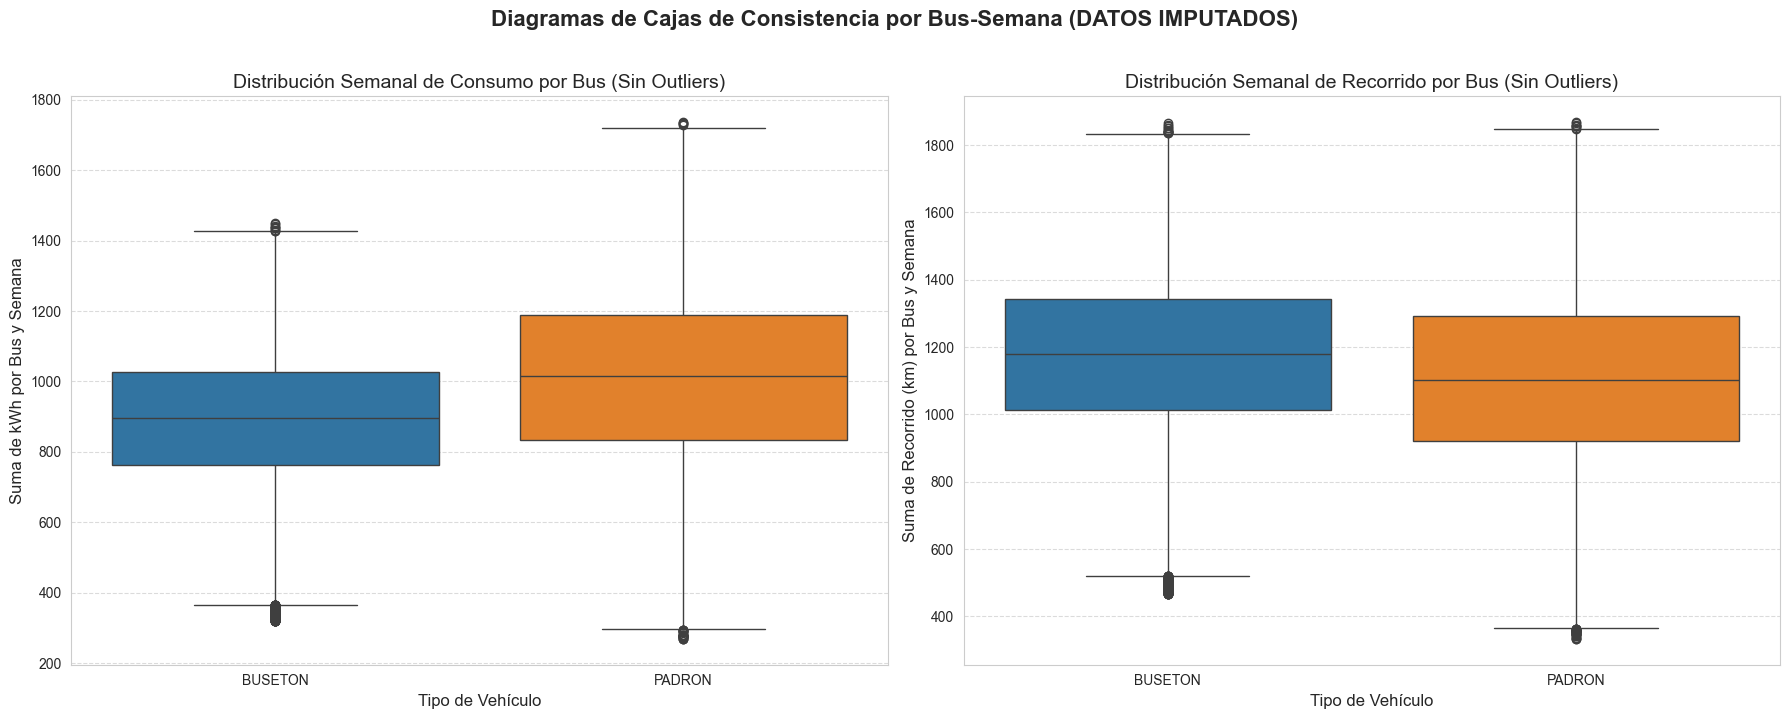

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# NOTA: Asumimos que df_ZMOIII_limpio ya está cargado y limpio

# --- 1. Agregación Semanal por Bus (IdVehiculo) y TIPO ---
df_limpio = df_ZMOIII_limpio.copy()
df_limpio['FechaCarga'] = pd.to_datetime(df_limpio['FechaCarga'])

# Agrupar por TIPO, IdVehiculo y Semana, sumando las métricas
df_bus_semanal = df_limpio.groupby(['TIPO', 'IdVehiculo', pd.Grouper(key='FechaCarga', freq='W-MON')]).agg(
    Energy_Semanal=('EnergyDeliveredKWh', 'sum'),
    Recorrido_Semanal=('Recorrido', 'sum')
).reset_index()

# Filtrar semanas inactivas (ambas métricas son cero)
df_bus_semanal = df_bus_semanal[
    (df_bus_semanal['Energy_Semanal'] > 0) |
    (df_bus_semanal['Recorrido_Semanal'] > 0)
].copy()


# --- 2. IMPUTACIÓN DE OUTLIERS CON LA MEDIANA (LIMPIEZA) ---

print("--- 🛠️ Imputación de Outliers con la Mediana ---")

df_imputado = df_bus_semanal.copy()
metricas = ['Energy_Semanal', 'Recorrido_Semanal']

for tipo in df_imputado['TIPO'].unique():
    df_tipo = df_imputado[df_imputado['TIPO'] == tipo]
    
    for col in metricas:
        # Calcular límites IQR
        Q1 = df_tipo[col].quantile(0.25)
        Q3 = df_tipo[col].quantile(0.75)
        IQR = Q3 - Q1
        
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Calcular Mediana
        mediana = df_tipo[col].median()
        
        # Identificar los Outliers Totales (Inferiores O Superiores)
        indices_outliers = df_tipo[
            (df_tipo[col] < limite_inferior) |
            (df_tipo[col] > limite_superior)
        ].index
        
        # Imputar: Reemplazar los valores atípicos por la mediana
        df_imputado.loc[indices_outliers, col] = mediana
        
        print(f"[{tipo} - {col}]: Se imputaron {len(indices_outliers)} registros con el valor de la mediana ({mediana:.2f}).")


# --- 3. Preparación y Creación de la Figura (DATOS IMPUTADOS) ---

df_plot_imputado = df_imputado.rename(columns={
    'Energy_Semanal': 'Energía Semanal (kWh) - Imputado',
    'Recorrido_Semanal': 'Recorrido Semanal (km) - Imputado'
})

palette_colors = {'BUSETON': '#1f77b4', 'PADRON': '#ff7f0e'}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Diagramas de Cajas de Consistencia por Bus-Semana (DATOS IMPUTADOS)',
             fontsize=16,
             fontweight='bold',
             y=1.02)

# --- GRÁFICO 1: Energía Entregada (kWh) ---
sns.boxplot(ax=axes[0], x='TIPO', y='Energía Semanal (kWh) - Imputado', 
            data=df_plot_imputado, palette=palette_colors)
axes[0].set_title('Distribución Semanal de Consumo por Bus (Sin Outliers)', fontsize=14)
axes[0].set_xlabel('Tipo de Vehículo', fontsize=12)
axes[0].set_ylabel('Suma de kWh por Bus y Semana', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- GRÁFICO 2: Recorrido (km) ---
sns.boxplot(ax=axes[1], x='TIPO', y='Recorrido Semanal (km) - Imputado', 
            data=df_plot_imputado, palette=palette_colors)
axes[1].set_title('Distribución Semanal de Recorrido por Bus (Sin Outliers)', fontsize=14)
axes[1].set_xlabel('Tipo de Vehículo', fontsize=12)
axes[1].set_ylabel('Suma de Recorrido (km) por Bus y Semana', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- 4. Verificación de Outliers en Datos Imputados ---
# (Se puede añadir una verificación para confirmar que el conteo es cero)

La dispersión de los datos se normaliza, eliminando los valores extremos (errores de medición e inactividad), lo cual se evidencia en los nuevos diagramas de cajas por la reducción de los whiskers y la ausencia de puntos atípicos.
Se garantiza que todos los registros contribuyan al análisis con un valor representativo de la operación normal en ruta. Esto elimina la incoherencia generada por los errores de Recorrido (5,000 km) y por la actividad cercana a cero.
El conjunto de datos resultante es limpio, consistente y coherente, siendo directamente apto para el cálculo robusto de la Línea de Base Energética (EnB) y los Indicadores de Desempeño Energético (EnPIs), al reflejar únicamente la condición operativa estándar.
.

### 2 Selección del periodo base


--- Estadísticas de Referencia Mensual (Hasta 01/09/2025) ---
Recorrido: Mediana=921274 km, Q1=845423 km, Q3=1052517 km
Energía: Mediana=755899 kWh, Q1=698280 kWh, Q3=845972 kWh
Registros: Mediana=772, Q1=770, Q3=962


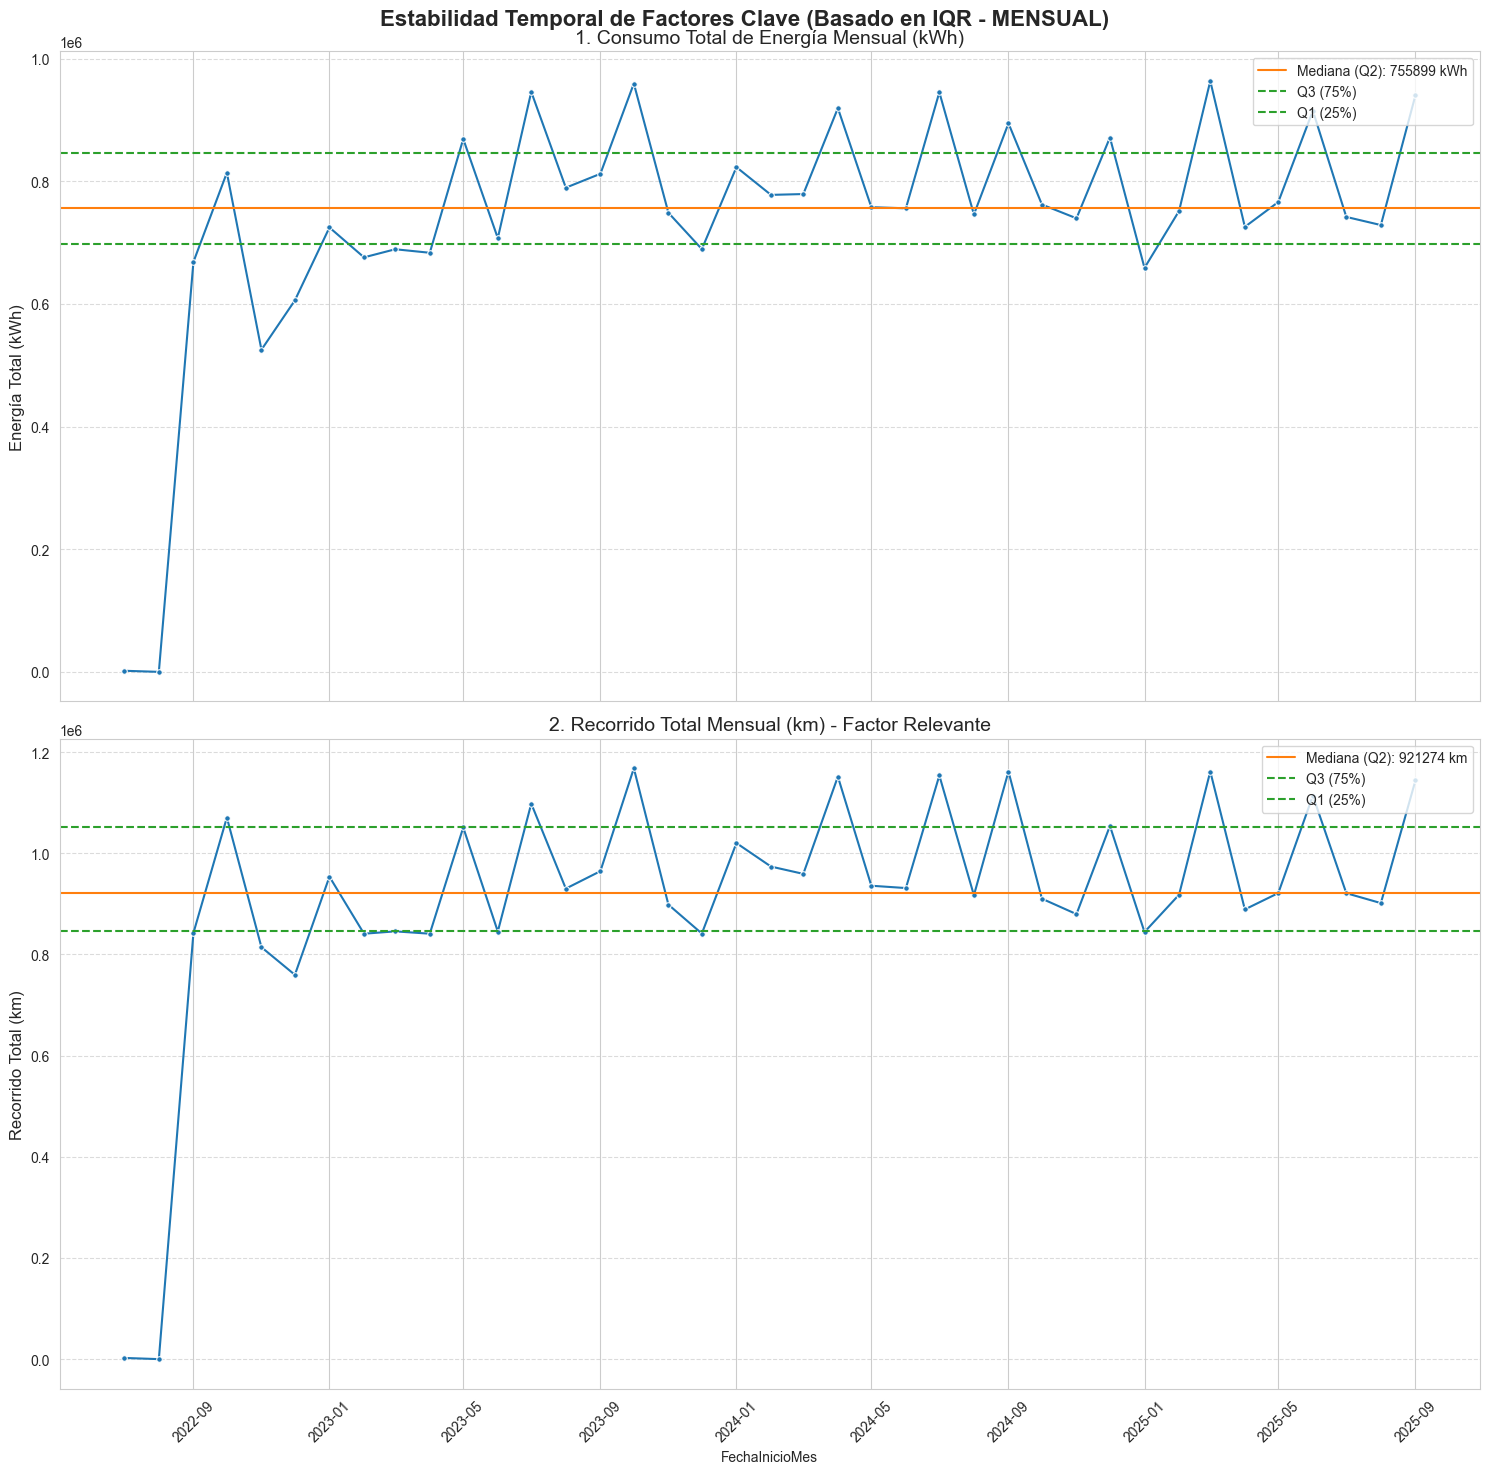

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# NOTA: Asumimos que df_imputado ya fue creado y limpiado con tu código anterior.

# --- 1. Agregación a nivel de FLOTA por MES (freq='MS') ---

# Asegurar que FechaCarga sea tipo datetime
df_imputado['FechaCarga'] = pd.to_datetime(df_imputado['FechaCarga'])

df_flota_mensual_limpio = df_imputado.groupby(
    pd.Grouper(key='FechaCarga', freq='MS')
).agg(
    Total_Energy_kWh=('Energy_Semanal', 'sum'),
    Total_Recorrido_km=('Recorrido_Semanal', 'sum'),
    Num_Registros=('IdVehiculo', 'count')
).reset_index().rename(columns={'FechaCarga': 'FechaInicioMes'})


# --- 2. Filtro de Fecha Límite (01/09/2025) y Cálculo de Estadísticas (IQR) ---

FECHA_LIMITE = pd.to_datetime('2025-09-01')

# Aplicar el filtro de fecha
df_flota_filtrado = df_flota_mensual_limpio[df_flota_mensual_limpio['FechaInicioMes'] <= FECHA_LIMITE].copy()

# Calcular estadísticas de referencia (Mediana, Q1, Q3) sobre el PERIODO FILTRADO
stats_iqr = {}
for col in ['Total_Energy_kWh', 'Total_Recorrido_km', 'Num_Registros']:
    Q1 = df_flota_filtrado[col].quantile(0.25)
    Q3 = df_flota_filtrado[col].quantile(0.75)
    mediana = df_flota_filtrado[col].median()
    stats_iqr[col] = {
        'mediana': mediana,
        'Q1': Q1,
        'Q3': Q3
    }

print("\n--- Estadísticas de Referencia Mensual (Hasta 01/09/2025) ---")
print(f"Recorrido: Mediana={stats_iqr['Total_Recorrido_km']['mediana']:.0f} km, Q1={stats_iqr['Total_Recorrido_km']['Q1']:.0f} km, Q3={stats_iqr['Total_Recorrido_km']['Q3']:.0f} km")
print(f"Energía: Mediana={stats_iqr['Total_Energy_kWh']['mediana']:.0f} kWh, Q1={stats_iqr['Total_Energy_kWh']['Q1']:.0f} kWh, Q3={stats_iqr['Total_Energy_kWh']['Q3']:.0f} kWh")
print(f"Registros: Mediana={stats_iqr['Num_Registros']['mediana']:.0f}, Q1={stats_iqr['Num_Registros']['Q1']:.0f}, Q3={stats_iqr['Num_Registros']['Q3']:.0f}")


# --- 3. Generación de Gráficos de Estabilidad Temporal (Con Mediana, Q1 y Q3) ---

fig, axes = plt.subplots(2, 1, figsize=(15, 15), sharex=True)
fig.suptitle('Estabilidad Temporal de Factores Clave (Basado en IQR - MENSUAL)', 
             fontsize=16, fontweight='bold', y=0.98)

# Colores de referencia
color_data = '#1f77b4'  # Azul
color_mediana = '#ff7f0e'  # Naranja (Línea central)
color_cuartil = '#2ca02c'  # Verde (Líneas Q1 y Q3)

# --- GRÁFICO 1: Energía Total Mensual (kWh) ---
ax0 = axes[0]
sns.lineplot(ax=ax0, x='FechaInicioMes', y='Total_Energy_kWh', data=df_flota_filtrado, 
             marker='o', markersize=4, color=color_data)
ax0.axhline(stats_iqr['Total_Energy_kWh']['mediana'], color=color_mediana, linestyle='-', label=f"Mediana (Q2): {stats_iqr['Total_Energy_kWh']['mediana']:.0f} kWh")
ax0.axhline(stats_iqr['Total_Energy_kWh']['Q3'], color=color_cuartil, linestyle='--', label="Q3 (75%)")
ax0.axhline(stats_iqr['Total_Energy_kWh']['Q1'], color=color_cuartil, linestyle='--', label="Q1 (25%)")
ax0.set_title('1. Consumo Total de Energía Mensual (kWh)', fontsize=14)
ax0.set_ylabel('Energía Total (kWh)', fontsize=12)
ax0.legend(loc='upper right')
ax0.grid(axis='y', linestyle='--', alpha=0.7)

# --- GRÁFICO 2: Recorrido Total Mensual (km) ---
ax1 = axes[1]
sns.lineplot(ax=ax1, x='FechaInicioMes', y='Total_Recorrido_km', data=df_flota_filtrado, 
             marker='o', markersize=4, color=color_data)
ax1.axhline(stats_iqr['Total_Recorrido_km']['mediana'], color=color_mediana, linestyle='-', label=f"Mediana (Q2): {stats_iqr['Total_Recorrido_km']['mediana']:.0f} km")
ax1.axhline(stats_iqr['Total_Recorrido_km']['Q3'], color=color_cuartil, linestyle='--', label="Q3 (75%)")
ax1.axhline(stats_iqr['Total_Recorrido_km']['Q1'], color=color_cuartil, linestyle='--', label="Q1 (25%)")
ax1.set_title('2. Recorrido Total Mensual (km) - Factor Relevante', fontsize=14)
ax1.set_ylabel('Recorrido Total (km)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El análisis de Estabilidad Temporal, basado en el Rango Intercuartílico (IQR) a nivel mensual, muestra que el nivel operativo de la flota (mediana de Energía y Recorrido) se estabiliza a partir de finales de 2022.
Si bien esta gráfica confirma que el nivel promedio de actividad es estable y que la mayor parte de los datos caen dentro de la banda Q1-Q3, esta información no es suficiente para seleccionar el Periodo Base.

La limitación clave es que el IQR no evalúa la consistencia de la operación dentro de cada mes. Es necesario analizar el Coeficiente de Variación (CV) de las series mensuales. El CV es crucial porque identifica si la operación, aunque estable en promedio, aún presenta alta dispersión o volatilidad semana a semana, lo cual podría sesgar el Periodo Base y requerir una fase de maduración más larga.


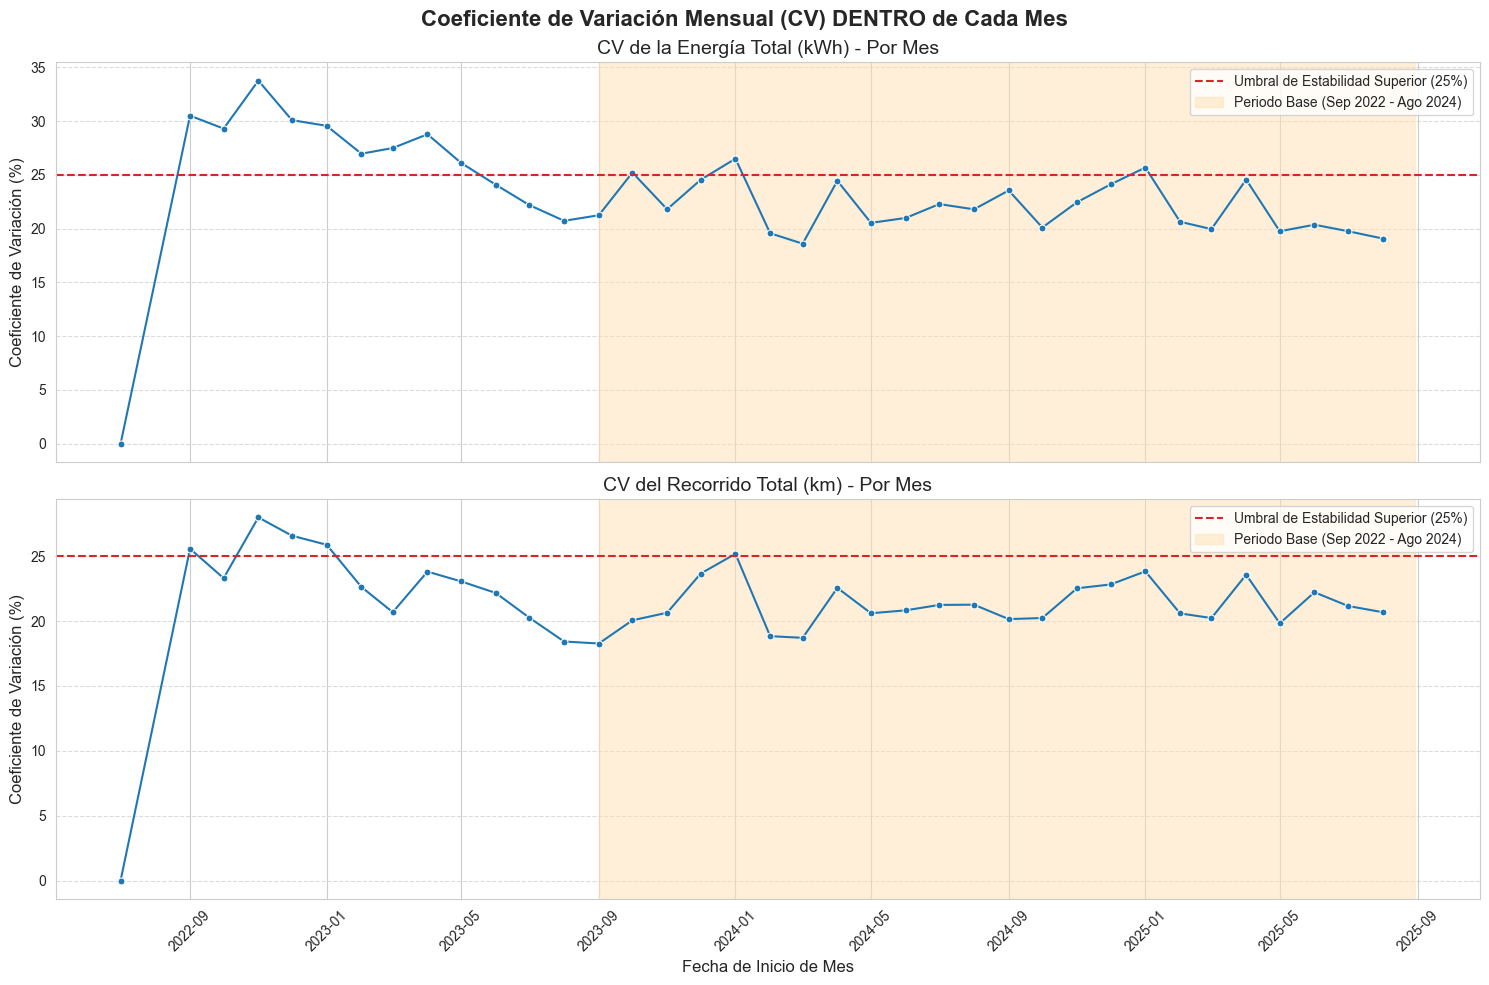

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURACIÓN INICIAL (Asumimos df_imputado ya existe) ---

# Asegurar que FechaCarga sea tipo datetime
df_imputado['FechaCarga'] = pd.to_datetime(df_imputado['FechaCarga'])

# Extraer la etiqueta única para cada mes y año
df_imputado['Año_Mes'] = df_imputado['FechaCarga'].dt.to_period('M') 

# --- 2. FILTRADO POR FECHA LÍMITE (01/09/2025) ---
FECHA_LIMITE = pd.to_datetime('2025-09-01')

# Aplicar el filtro de fecha *antes* de la agregación final si es necesario,
# aunque el filtro se aplicará mejor en la tabla final o en el gráfico.
# Para este análisis, agruparemos todo y luego filtraremos para el gráfico
# para mantener consistencia.


# --- 3. AGREGACIÓN Y CÁLCULO DE ESTADÍSTICAS POR AÑO Y MES ---

# Agrupar por el par (Año, Mes) y calcular media y desviación estándar de las variables SEMANALES
df_anual_mensual_stats = df_imputado.groupby(['Año_Mes']).agg(
    Media_Energy=('Energy_Semanal', 'mean'),
    Std_Energy=('Energy_Semanal', 'std'),
    Media_Recorrido=('Recorrido_Semanal', 'mean'),
    Std_Recorrido=('Recorrido_Semanal', 'std'),
    Num_Registros=('IdVehiculo', 'count')
).reset_index()

# Convertir 'Año_Mes' a datetime para graficar
df_anual_mensual_stats['Fecha_Plot'] = df_anual_mensual_stats['Año_Mes'].dt.to_timestamp()

# Filtrar hasta el límite requerido
df_anual_mensual_stats_filtrado = df_anual_mensual_stats[
    df_anual_mensual_stats['Fecha_Plot'] < FECHA_LIMITE
].copy()


# --- 4. CÁLCULO DEL COEFICIENTE DE VARIACIÓN (CV) POR AÑO Y MES ---

# CV = (Std / Media) * 100
df_anual_mensual_stats_filtrado['CV_Energy (%)'] = (
    df_anual_mensual_stats_filtrado['Std_Energy'] / df_anual_mensual_stats_filtrado['Media_Energy']
) * 100
df_anual_mensual_stats_filtrado['CV_Recorrido (%)'] = (
    df_anual_mensual_stats_filtrado['Std_Recorrido'] / df_anual_mensual_stats_filtrado['Media_Recorrido']
) * 100


# --- 5. Generación de Gráficos de Serie Temporal del CV ---

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Coeficiente de Variación Mensual (CV) DENTRO de Cada Mes',
             fontsize=16, fontweight='bold', y=0.98)

# Colores y umbral de referencia (e.g., 25% para el límite superior de estabilidad)
umbral_cv_alto = 25 
color_data = '#1f77b4' # Azul
color_umbral = '#d62728' # Rojo

# --- GRÁFICO 1: CV de Energía ---
ax0 = axes[0]
sns.lineplot(ax=ax0, x='Fecha_Plot', y='CV_Energy (%)', data=df_anual_mensual_stats_filtrado, 
             marker='o', markersize=5, color=color_data)
ax0.axhline(umbral_cv_alto, color=color_umbral, linestyle='--', label=f'Umbral de Estabilidad Superior ({umbral_cv_alto}%)')
ax0.set_title('CV de la Energía Total (kWh) - Por Mes', fontsize=14)
ax0.set_ylabel('Coeficiente de Variación (%)', fontsize=12)
ax0.set_xlabel('')
ax0.legend()
ax0.grid(axis='y', linestyle='--', alpha=0.7)

# --- GRÁFICO 2: CV de Recorrido ---
ax1 = axes[1]
sns.lineplot(ax=ax1, x='Fecha_Plot', y='CV_Recorrido (%)', data=df_anual_mensual_stats_filtrado, 
             marker='o', markersize=5, color=color_data)
ax1.axhline(umbral_cv_alto, color=color_umbral, linestyle='--', label=f'Umbral de Estabilidad Superior ({umbral_cv_alto}%)')
ax1.set_title('CV del Recorrido Total (km) - Por Mes', fontsize=14)
ax1.set_xlabel('Fecha de Inicio de Mes', fontsize=12)
ax1.set_ylabel('Coeficiente de Variación (%)', fontsize=12)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Marcar el Periodo Base de 24 meses (Sep 2022 - Ago 2024)
inicio_24m = pd.to_datetime('2023-09-01')
fin_24m = pd.to_datetime('2025-08-30') # Hasta el inicio del último mes

# Usar un sombreado para resaltar visualmente el Periodo Base de 24 meses
for ax in axes:
    ax.axvspan(inicio_24m, fin_24m, color='#ffe0b2', alpha=0.5, label='Periodo Base (Sep 2022 - Ago 2024)')
    ax.legend(loc='upper right')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El anterior análisis mide la consistencia interna de la operación. En palabras sencillas, un CV bajo significa que el consumo de energía y el recorrido semanal de la flota son altamente predecibles y se mantienen estables semanas a semana.

La gráfica del CV muestra claramente que la operación experimentó una fase de alta volatilidad (CV alto) que finalizó en agosto de 2023. A partir de septiembre de 2023, el CV del Consumo de Energía desciende notablemente, siendo este el indicador más fuerte de que el sistema energético de la flota ha entrado en su fase de máxima consistencia operativa. En este punto, la operación se vuelve más  predecible y estable. Esta consistencia en el consumo de energía, sumada a la estabilidad de los niveles de actividad confirmada por el análisis IQR, justifica plenamente la selección del período más extenso.

Por lo tanto, el Periodo Base Energético se establece desde septiembre de 2023 hasta agosto de 2025. Este período de 24 meses continuos garantiza la mayor solidez y precisión para el modelo de normalización, ya que utiliza el segmento de datos con la mayor consistencia operativa registrada.

### 3 Identificación de variables relevantes

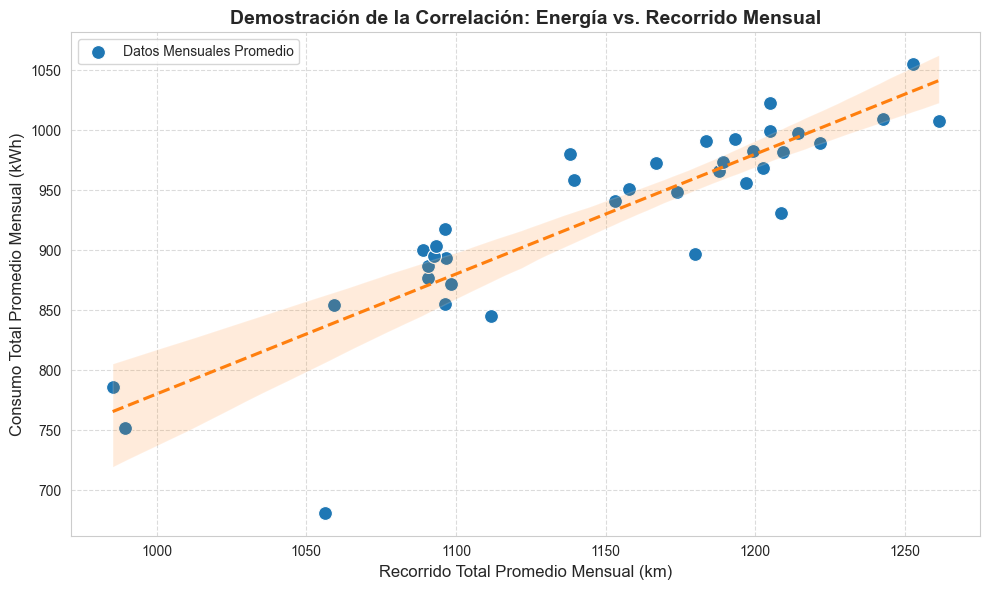

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. ASUMIMOS df_anual_mensual_stats_filtrado está en memoria ---
# Index: ['Año_Mes', 'Media_Energy', 'Std_Energy', 'Media_Recorrido',
#        'Std_Recorrido', 'Num_Registros', 'Fecha_Plot', 'CV_Energy (%)',
#        'CV_Recorrido (%)']

# --- 2. CONFIGURACIÓN DEL GRÁFICO DE DISPERSIÓN ---

plt.figure(figsize=(10, 6))

# Crear el diagrama de dispersión
# Eje X: Media_Recorrido (Factor Independiente)
# Eje Y: Media_Energy (Consumo Dependiente)
sns.scatterplot(
    x='Media_Recorrido', 
    y='Media_Energy', 
    data=df_anual_mensual_stats_filtrado,
    marker='o',
    s=100, # Tamaño de los puntos
    color='#1f77b4', # Azul
    label='Datos Mensuales Promedio'
)

# Ajustar y dibujar la línea de regresión (Tendencia Lineal)
# Esto demuestra formalmente la relación funcional entre ambas variables
sns.regplot(
    x='Media_Recorrido',
    y='Media_Energy',
    data=df_anual_mensual_stats_filtrado,
    scatter=False, # No duplicar los puntos
    color='#ff7f0e', # Naranja
    ci=95, # Intervalo de confianza (opcional, pero útil)
    line_kws={'linestyle': '--', 'label': 'Línea de Regresión'}
)

# --- 3. ETIQUETAS Y TÍTULOS ---

plt.title('Demostración de la Correlación: Energía vs. Recorrido Mensual', 
          fontsize=14, fontweight='bold')
plt.xlabel('Recorrido Total Promedio Mensual (km)', fontsize=12)
plt.ylabel('Consumo Total Promedio Mensual (kWh)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Se determinó que el Recorrido Total (km) es el Factor relevante que más afecta directamente el Consumo de Energía de la flota, y por ende, es la variable escogida para la normalización de la Línea de Base Energética.
El impacto del Recorrido (km) sobre el consumo energético es directo y lineal. Esta relación funcional se demuestra con la alta correlación positiva observada entre el Recorrido Mensual y el Consumo de Energía Mensual. A medida que el Recorrido (km) aumenta, el Consumo de Energía (kWh) también lo hace, lo cual es la base del modelo de regresión lineal utilizado para predecir el consumo.

### 4. Construcción de la LBEn

Se procederá a la construcción de la Línea de Base Energética (LBEn) Normalizada. Este proceso establecerá el consumo de energía esperado de la flota bajo condiciones normales de operación, sirviendo como referencia fundamental para medir el desempeño energético futuro. Para la normalización, se utilizarán modelos matemáticos, específicamente la regresión lineal. 

Dada la necesidad de capturar las diferencias inherentes en el consumo, los datos de energía y recorrido se agruparán con una alta granularidad: por cada bus semanalmente y, de manera fundamental, por tipo de bus (Padron vs. Busetón). Esta diferenciación es imprescindible porque el bus Padron es físicamente más grande, consume una mayor cantidad de energía y posee una batería de mayor capacidad, lo que obliga a modelar su consumo de forma separada. 

Puesto que el Recorrido Total (km) ha sido validado como el Factor Relevante, el modelo de regresión lineal establecerá la relación funcional entre el Consumo de Energía y dicho Recorrido, lo que permitirá predecir el consumo esperado para cualquier nivel de actividad, eliminando el efecto de la variación en la producción (km) sobre el consumo de energía.

In [20]:
df_imputado

,TIPO,IdVehiculo,FechaCarga,Energy_Semanal,Recorrido_Semanal,Año_Mes
0,BUSETON,634001,2022-09-05,715,694.0,2022-09
1,BUSETON,634001,2022-09-12,940,1467.0,2022-09
2,BUSETON,634001,2022-09-19,1245,1364.0,2022-09
3,BUSETON,634001,2022-09-26,880,1355.0,2022-09
4,BUSETON,634001,2022-10-03,1022,1227.0,2022-10
...,...,...,...,...,...,...
32350,PADRON,637068,2025-10-20,676,723.0,2025-10
32351,PADRON,637068,2025-10-27,1084,1162.0,2025-10
32352,PADRON,637068,2025-11-03,581,638.0,2025-11
32353,PADRON,637068,2025-11-10,690,749.0,2025-11


In [21]:
df_imputado.columns

Index(['TIPO', 'IdVehiculo', 'FechaCarga', 'Energy_Semanal',
       'Recorrido_Semanal', 'Año_Mes'],
      dtype='object')

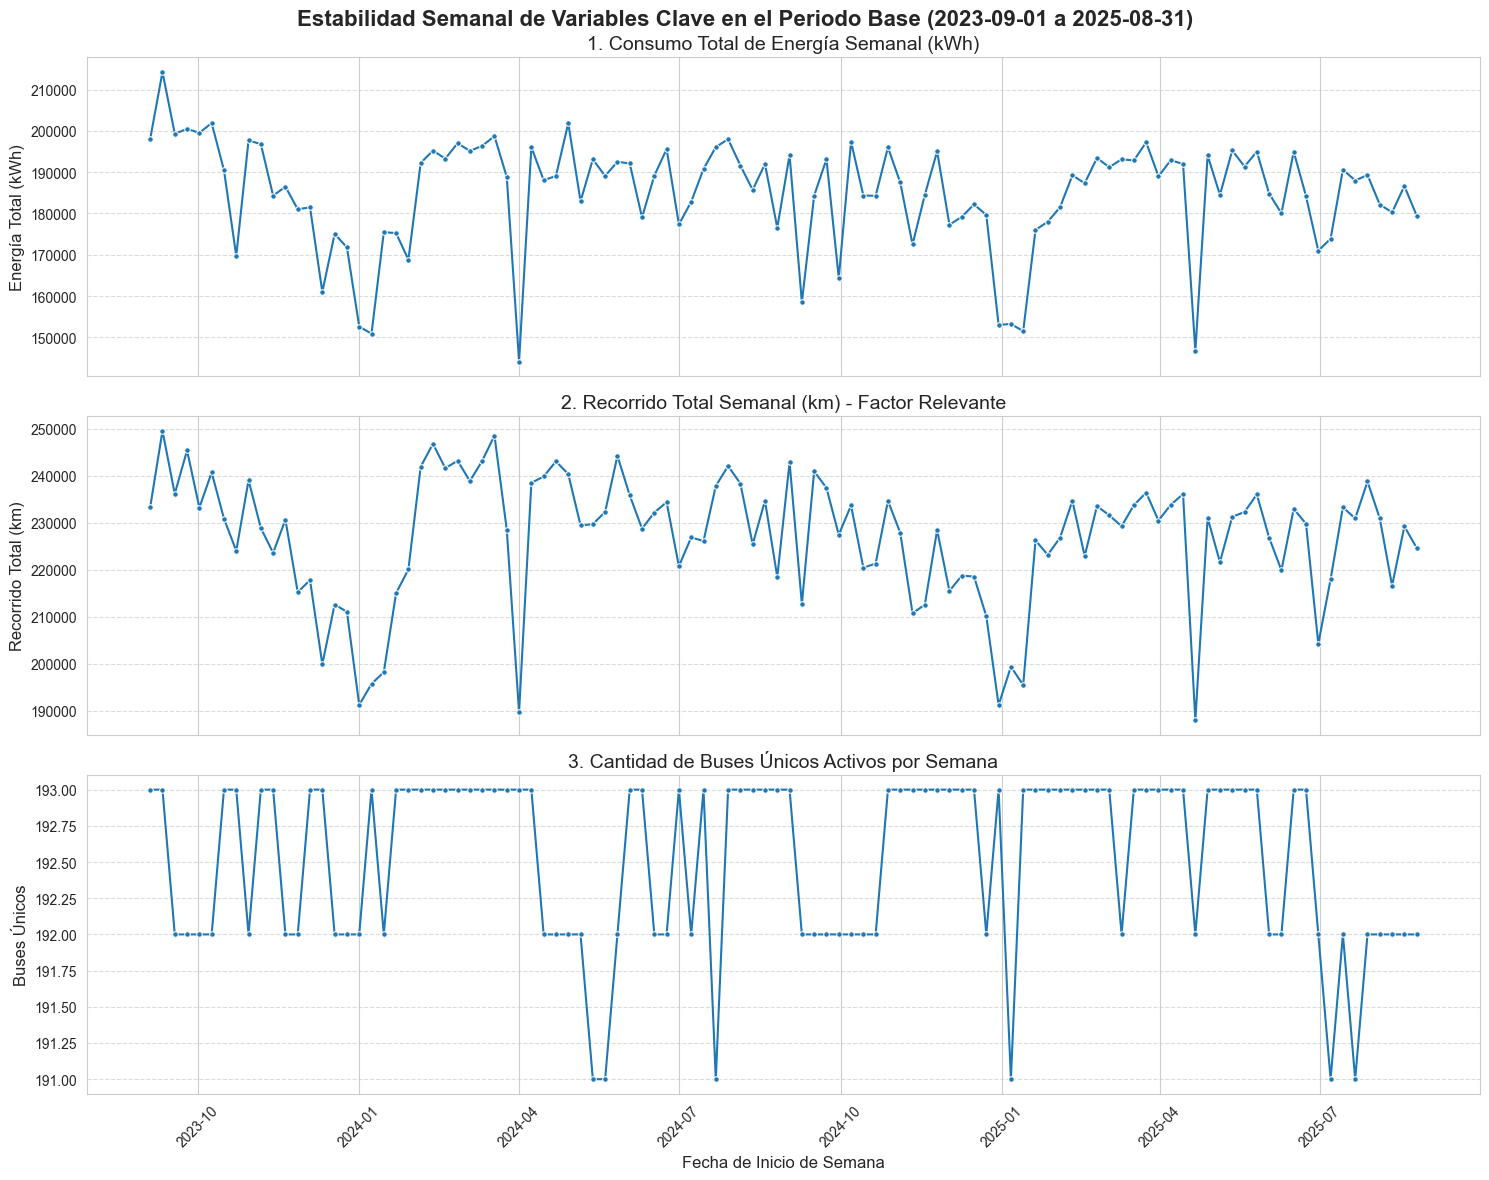


✅ DataFrame de trabajo renombrado y filtrado:
Nombre del DataFrame: df_lben_data
Periodo de Fechas: 2023-09-04 a 2025-08-25
   FechaCarga     TIPO  IdVehiculo  Energy_Semanal  Recorrido_Semanal
52 2023-09-04  BUSETON      634001            1074             1542.0
53 2023-09-11  BUSETON      634001             954             1120.0
54 2023-09-18  BUSETON      634001            1059             1239.0
55 2023-09-25  BUSETON      634001            1118             1563.0
56 2023-10-02  BUSETON      634001            1128             1671.0


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURACIÓN DEL PERIODO BASE Y RENOMBRADO ---

# 1.1 Definición de fechas del Periodo Base (24 meses)
INICIO_ENB = pd.to_datetime('2023-09-01')
FIN_ENB = pd.to_datetime('2025-08-31') # Incluye todo el mes de agosto de 2025

# 1.2 Asumiendo 'df_imputado' está cargado y tiene el índice especificado
# (Si no está cargado, este paso fallará)
df_lben_data = df_imputado.copy()

# 1.3 Filtrar el DataFrame al Periodo Base
df_lben_data = df_lben_data[
    (df_lben_data['FechaCarga'] >= INICIO_ENB) & 
    (df_lben_data['FechaCarga'] <= FIN_ENB)
].copy()

# 1.4 Seleccionar las columnas relevantes para el análisis semanal
# Dejaremos 'TIPO' para el análisis por bus, pero para la gráfica general solo usaremos las variables clave.
df_lben_data = df_lben_data[['FechaCarga', 'TIPO', 'IdVehiculo', 'Energy_Semanal', 'Recorrido_Semanal']]


# --- 2. AGREGACIÓN SEMANAL PARA LA FLOTA (Confirmación de Estabilidad) ---

# Agrupar a nivel de flota por semana (freq='W-MON' o 'W' por defecto)
df_flota_semanal = df_lben_data.groupby(
    pd.Grouper(key='FechaCarga', freq='W-MON')
).agg(
    Total_Energy_kWh=('Energy_Semanal', 'sum'),
    Total_Recorrido_km=('Recorrido_Semanal', 'sum'),
    # Contar buses únicos por semana
    Num_Buses_Unicos=('IdVehiculo', 'nunique')
).reset_index()


# --- 3. GENERACIÓN DE GRÁFICOS DE ESTABILIDAD SEMANAL ---

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig.suptitle(f'Estabilidad Semanal de Variables Clave en el Periodo Base ({INICIO_ENB.date()} a {FIN_ENB.date()})', 
             fontsize=16, fontweight='bold', y=0.98)

color_data = '#1f77b4'  # Azul

# --- GRÁFICO 1: Energía Total Semanal (kWh) ---
ax0 = axes[0]
sns.lineplot(ax=ax0, x='FechaCarga', y='Total_Energy_kWh', data=df_flota_semanal, 
             marker='o', markersize=4, color=color_data)
ax0.set_title('1. Consumo Total de Energía Semanal (kWh)', fontsize=14)
ax0.set_ylabel('Energía Total (kWh)', fontsize=12)
ax0.grid(axis='y', linestyle='--', alpha=0.7)

# --- GRÁFICO 2: Recorrido Total Semanal (km) ---
ax1 = axes[1]
sns.lineplot(ax=ax1, x='FechaCarga', y='Total_Recorrido_km', data=df_flota_semanal, 
             marker='o', markersize=4, color=color_data)
ax1.set_title('2. Recorrido Total Semanal (km) - Factor Relevante', fontsize=14)
ax1.set_ylabel('Recorrido Total (km)', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# --- GRÁFICO 3: Cantidad de Buses Únicos Semanales ---
ax2 = axes[2]
sns.lineplot(ax=ax2, x='FechaCarga', y='Num_Buses_Unicos', data=df_flota_semanal, 
             marker='o', markersize=4, color=color_data)
ax2.set_title('3. Cantidad de Buses Únicos Activos por Semana', fontsize=14)
ax2.set_xlabel('Fecha de Inicio de Semana', fontsize=12)
ax2.set_ylabel('Buses Únicos', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✅ DataFrame de trabajo renombrado y filtrado:")
print(f"Nombre del DataFrame: df_lben_data")
print(f"Periodo de Fechas: {df_lben_data['FechaCarga'].min().date()} a {df_lben_data['FechaCarga'].max().date()}")
print(df_lben_data.head())

In [23]:
len(df_lben_data)

20022

In [24]:
52*2*193

20072


El análisis de Estabilidad Semanal de Variables Clave confirma la solidez y representatividad del Periodo Base de 24 meses escogido previamente (septiembre de 2023 a agosto de 2025).
La estabilidad es evidente en las variables principales: el Consumo de Energía Semanal (kWh) y el Recorrido Total Semanal (km) se mantienen en un rango consistente y sin tendencias de crecimiento o decrecimiento descontroladas a lo largo de los dos años. Esto valida que la operación de la flota, tanto en consumo como en actividad, es estable y apta para la construcción de la Línea de Base Energética (LBEn).
En cuanto a la Completitud Operacional, la gráfica de Buses Únicos Activos por Semana muestra que el número de registros es altamente estable. Las pocas variaciones que se observan corresponden a ausencias mínimas de uno o dos buses, lo cual es entendible y esperable dentro de la operación real (ej., mantenimientos o revisiones) y no afecta significativamente la construcción del modelo, dada la alta consistencia del resto de la flota. Finalmente, el número total de registros en este periodo de 24 meses (aproximadamente 104 semanas) es de 20022 se acerca al producto de estas semanas por el número de buses operacionales, asegurando una cobertura histórica robusta.


La metodología para el cálculo de la LBEN será la siguiente:
El objetivo de esta metodología es establecer una Línea Base de Energía (LBEN) robusta y validada estadísticamente para cada tipo de bus, permitiendo predecir el consumo energético esperado a partir del recorrido.
Fase 1: Preparación y Separación Estratificada de Datos
Esta fase asegura que los modelos sean entrenados y probados con conjuntos de datos representativos y no vistos.
•	Identificación: Se identifican los tipos de buses únicos (BUSETÓN y PADRÓN) para crear modelos de regresión independientes.
•	Partición Estratificada: Los datos se dividen en tres conjuntos de forma estratificada por tipo de bus para garantizar que cada subconjunto (Entrenamiento, Test, Validación) contenga una proporción adecuada de cada categoría, evitando sesgos.
o	BUSETÓN: Partición estándar (80% Entrenamiento, 10% Test, 10% Validación).
o	PADRÓN: Partición ajustada (90% Entrenamiento, 5% Test, 5% Validación) para minimizar el sobreajuste previamente detectado al aumentar el volumen de aprendizaje.
•	Definición de Variables: Se definen las variables para el modelado:
o	Variable Predictora (X): Recorrido Semanal.
o	Variable Objetivo (Y): Consumo de Energía Semanal.

Fase 2: Modelado por Regresión Lineal Simple (Cálculo de la LBEN)
Se aplica el modelo de regresión a cada tipo de bus.
•	Ajuste del Modelo: Se utiliza la regresión lineal simple para ajustar la ecuación en el conjunto de Entrenamiento.
•	Definición de LBEN: La ecuación resultante se convierte en la LBEN, que establece el consumo ideal o esperado para un recorrido dado.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Para obtener el R²

# --- 0. CONFIGURACIÓN INICIAL Y FILTRADO DEL PERIODIO BASE ---

# 0.1 Definición de fechas del Periodo Base (Este ejemplo usará 24 meses)
INICIO_ENB = pd.to_datetime('2023-09-01')
FIN_ENB = pd.to_datetime('2025-08-31')

# Cálculo dinámico del número de meses
num_meses = (FIN_ENB.year - INICIO_ENB.year) * 12 + (FIN_ENB.month - INICIO_ENB.month) + 1
periodo_texto = f'{num_meses} Meses'

# 0.2 Filtrar el DataFrame al Periodo Base
# ASUMIMOS df_imputado está cargado (es la fuente de datos bus-semana)
# Nota: La línea 'df_lben_data = df_imputado.copy()' debe estar presente si df_imputado existe.
# df_lben_data = df_imputado.copy() 

df_lben_data = df_imputado.copy() # Se asume la copia del dataframe fuente para la ejecución

df_lben_data = df_lben_data[
    (df_lben_data['FechaCarga'] >= INICIO_ENB) & 
    (df_lben_data['FechaCarga'] <= FIN_ENB)
].copy()

df_regresion_data = df_lben_data.copy()



In [26]:
df_regresion_data

,TIPO,IdVehiculo,FechaCarga,Energy_Semanal,Recorrido_Semanal,Año_Mes
52,BUSETON,634001,2023-09-04,1074,1542.0,2023-09
53,BUSETON,634001,2023-09-11,954,1120.0,2023-09
54,BUSETON,634001,2023-09-18,1059,1239.0,2023-09
55,BUSETON,634001,2023-09-25,1118,1563.0,2023-09
56,BUSETON,634001,2023-10-02,1128,1671.0,2023-10
...,...,...,...,...,...,...
32338,PADRON,637068,2025-07-28,853,874.0,2025-07
32339,PADRON,637068,2025-08-04,630,723.0,2025-08
32340,PADRON,637068,2025-08-11,861,926.0,2025-08
32341,PADRON,637068,2025-08-18,1017,1103.0,2025-08


In [27]:
df_regresion_data.columns

Index(['TIPO', 'IdVehiculo', 'FechaCarga', 'Energy_Semanal',
       'Recorrido_Semanal', 'Año_Mes'],
      dtype='object')

✅ Tipos de buses detectados: BUSETON, PADRON

🚌 Procesando Tipo de Bus: BUSETON
  - Partición: Entrenamiento: 10373 | Test: 1297 | Validación: 1297
  - Coeficiente (Pendiente): 0.6522
  - Intersección: 135.4048
  - R² en Test: 0.7225

✅ Aplicando partición ESPECIAL para PADRON: 90/5/5

🚌 Procesando Tipo de Bus: PADRON
  - Partición: Entrenamiento: 6349 | Test: 353 | Validación: 353
  - Coeficiente (Pendiente): 0.8099
  - Intersección: 117.9464
  - R² en Test: 0.7745


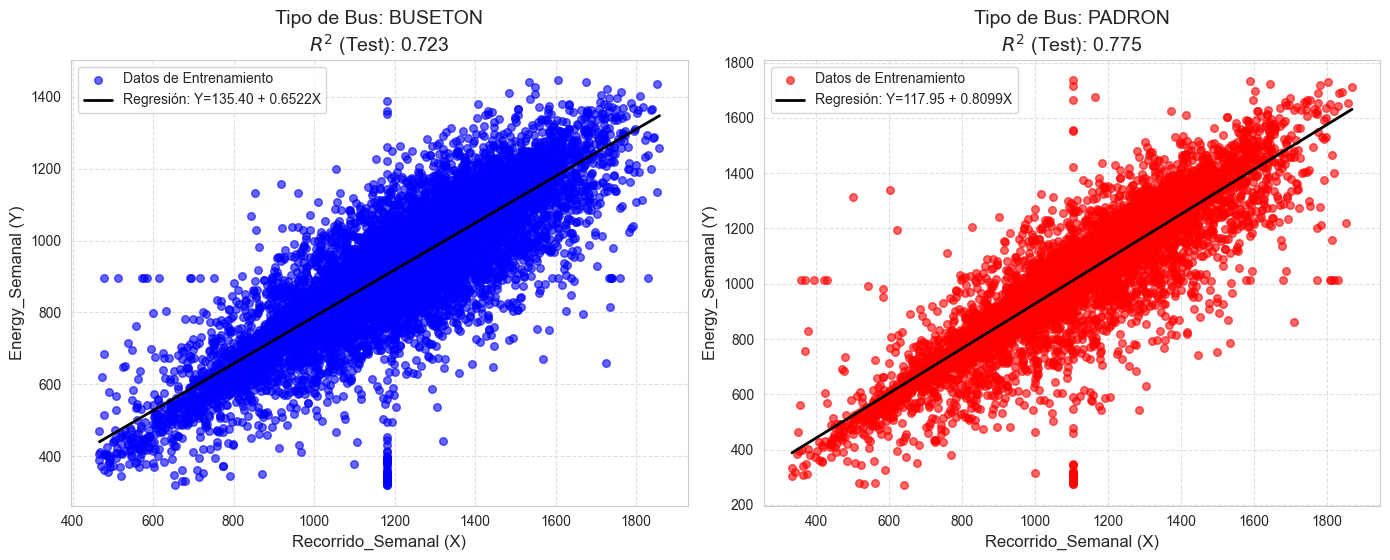


📋 RESULTADOS FINALES

--- BUSETON ---
Ecuación: Y = 135.40 + 0.6522X
R² (Entrenamiento): 0.6952
R² (Test): 0.7225
R² (Validación): 0.6950
Diferencia R² (Entrenamiento - Validación): 0.0002
Conclusión General: Estable (Buena generalización).

--- PADRON ---
Ecuación: Y = 117.95 + 0.8099X
R² (Entrenamiento): 0.7522
R² (Test): 0.7745
R² (Validación): 0.8210
Diferencia R² (Entrenamiento - Validación): -0.0688
Conclusión General: Estable (Buena generalización).


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np


# --- 1. Detección de Tipos y Separación por Tipo ---
tipos_unicos = df_regresion_data['TIPO'].unique()
dataframes_por_tipo = {tipo: df_regresion_data[df_regresion_data['TIPO'] == tipo].copy() for tipo in tipos_unicos}

print(f"✅ Tipos de buses detectados: {', '.join(tipos_unicos)}")

# --- 2. Procesamiento, Entrenamiento y Evaluación Individual por TIPO (Con Partición Dinámica) ---
modelos = {}
plots_data = {}
resultados_resumen = {}

def evaluar_modelo(modelo, df):
    """Calcula las métricas R², MSE y MAE para un modelo en un subconjunto de datos."""
    if len(df) < 1:
        return {'R2': np.nan, 'MSE': np.nan, 'MAE': np.nan}
    
    X = df['Recorrido_Semanal'].values.reshape(-1, 1)
    y = df['Energy_Semanal'].values
    y_pred = modelo.predict(X)
    
    return {
        'R2': r2_score(y, y_pred),
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred)
    }

for tipo, df_tipo in dataframes_por_tipo.items():
    if len(df_tipo) < 3:
        print(f"\n⚠️ El TIPO '{tipo}' tiene muy pocas muestras para entrenar.")
        continue
    
    # 2.1. Definición de la Proporción de Partición
    if tipo == 'PADRON':
        # 90% Entrenamiento, 10% Temporal (5% Test + 5% Validación)
        test_size_global = 0.10
        print(f"\n✅ Aplicando partición ESPECIAL para PADRON: 90/5/5")
    else:
        # 80% Entrenamiento, 20% Temporal (10% Test + 10% Validación)
        test_size_global = 0.20
    
    print(f"\n==============================================")
    print(f"🚌 Procesando Tipo de Bus: {tipo}")
    print(f"==============================================")
    
    # 2.2. Partición de Datos (80%/20% o 90%/10% para Entrenamiento/Temporal)
    
    # Entrenamiento vs Temporal (20% o 10%)
    df_train, df_temp = train_test_split(
        df_tipo,
        test_size=test_size_global,
        random_state=42
    )

    # Test vs Validación (Mitad del conjunto temporal: 10%/10% o 5%/5%)
    df_test, df_validation = train_test_split(
        df_temp,
        test_size=0.5, # Siempre 50% de df_temp
        random_state=42
    )

    print(f"  - Partición: Entrenamiento: {len(df_train)} | Test: {len(df_test)} | Validación: {len(df_validation)}")

    # 2.3. Entrenamiento
    X_train = df_train['Recorrido_Semanal'].values.reshape(-1, 1)
    y_train = df_train['Energy_Semanal'].values
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)
    modelos[tipo] = modelo

    # 2.4. Evaluación en los 3 conjuntos
    metricas_train = evaluar_modelo(modelo, df_train)
    metricas_test = evaluar_modelo(modelo, df_test)
    metricas_val = evaluar_modelo(modelo, df_validation)

    # 2.5. Almacenamiento de resultados
    resultados_resumen[tipo] = {
        'Ecuación': f"Y = {modelo.intercept_:.2f} + {modelo.coef_[0]:.4f}X",
        'R² (Entrenamiento)': metricas_train['R2'],
        'R² (Test)': metricas_test['R2'],
        'R² (Validación)': metricas_val['R2'],
        'MAE (Validación)': metricas_val['MAE'],
    }

    # 2.6. Datos para la Gráfica
    plots_data[tipo] = {
        'df_train': df_train,
        'coef': modelo.coef_[0],
        'intercept': modelo.intercept_,
        'r2_test': metricas_test['R2']
    }
    
    print(f"  - Coeficiente (Pendiente): {modelo.coef_[0]:.4f}")
    print(f"  - Intersección: {modelo.intercept_:.4f}")
    print(f"  - R² en Test: {metricas_test['R2']:.4f}")

# --- 3. Visualización de Resultados (Gráficas) ---
n_tipos = len(plots_data)
# ... (El código de las gráficas es el mismo que en el bloque anterior y no necesita cambios)
if n_tipos > 0:
    fig, axes = plt.subplots(1, n_tipos, figsize=(7 * n_tipos, 6))
    if n_tipos == 1: axes = [axes]
    colores = ['blue', 'red', 'green', 'purple', 'orange', 'brown'] 
    
    for i, tipo in enumerate(plots_data.keys()):
        ax = axes[i]
        data = plots_data[tipo]
        coef, intercept, r2 = data['coef'], data['intercept'], data['r2_test']
        df_train = data['df_train']
        color = colores[i % len(colores)]

        X_train = df_train['Recorrido_Semanal'].values
        y_train = df_train['Energy_Semanal'].values
        X_reg = np.array([[X_train.min()], [X_train.max()]])
        y_reg = intercept + coef * X_reg.flatten()
        
        ax.scatter(X_train, y_train, label='Datos de Entrenamiento', color=color, alpha=0.6, s=30)
        ax.plot(X_reg, y_reg, color='black', linewidth=2, label=f'Regresión: Y={intercept:.2f} + {coef:.4f}X')
        ax.set_title(f'Tipo de Bus: {tipo}\n$R^2$ (Test): {r2:.3f}', fontsize=14)
        ax.set_xlabel('Recorrido_Semanal (X)', fontsize=12)
        ax.set_ylabel('Energy_Semanal (Y)', fontsize=12)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

# --- 4. Resultados para la Tabla y Conclusiones (Formato de Salida) ---
print("\n==============================================")
print("📋 RESULTADOS FINALES")
print("==============================================")
for tipo, res in resultados_resumen.items():
    r2_entrenamiento = res['R² (Entrenamiento)']
    r2_validacion = res['R² (Validación)']
    
    # Cálculo de la diferencia (Overfitting)
    dif_r2 = r2_entrenamiento - r2_validacion
    
    # Determinación de la Generalización (Usando R² Test vs R² Validación)
    coherencia = "No evaluable."
    if not np.isnan(res['R² (Test)']) and not np.isnan(r2_validacion):
        if abs(res['R² (Test)'] - r2_validacion) < 0.05:
            coherencia = "Estable (Buena generalización)."
        elif r2_validacion < res['R² (Test)']:
            coherencia = "Sobreajuste Leve."
        else:
            coherencia = "Inconsistente."

    print(f"\n--- {tipo} ---")
    print(f"Ecuación: {res['Ecuación']}")
    print(f"R² (Entrenamiento): {r2_entrenamiento:.4f}")
    print(f"R² (Test): {res['R² (Test)']:.4f}")
    print(f"R² (Validación): {r2_validacion:.4f}")
    print(f"Diferencia R² (Entrenamiento - Validación): {dif_r2:.4f}")
    #print(f"MAE (Validación): {res['MAE (Validación)']:.2f}") # Descomentar si se requiere MAE
    print(f"Conclusión General: {coherencia}")

Ambos modelos demuestran una fuerte validez estadística, confirmando que el Recorrido Semanal es el factor clave para predecir el Consumo de Energía Semanal.

	Modelo BUSETON: 
    
Validez (R^2 Test = 0.7225): El modelo explica el 72.25% de la variabilidad del consumo de energía del BUSETON.

Sobreajuste: La diferencia entre R^2 Entrenamiento (0.6952) y R^2 Validación (0.6950) es de tan solo 0.0002. Este valor cercano a cero es la señal de sobreajuste nulo.

Coherencia: El rendimiento es altamente estable. Aunque el R^2 Test es más alto que Entrenamiento/Validación, la estabilidad entre los conjuntos de entrenamiento y validación es excelente, confirmando que el R^2 Test es una medida fiable del rendimiento futuro.

	Modelo PADRÓN: 
    
Validez (R^2  Test = 0.7745): El modelo explica el 77.45% de la variabilidad del consumo de energía del PADRÓN. Este es el ajuste más alto entre los dos modelos, validando que el recorrido es un predictor muy fuerte.

Sobreajuste: La diferencia entre R^2  Entrenamiento (0.7522) y R^2  Validación (0.8210) es de -0.0688. Este valor negativo indica que el modelo no solo no tiene sobreajuste, sino que es extremadamente robusto. El rendimiento en el conjunto de Validación es superior al rendimiento de Entrenamiento.

Coherencia: El rendimiento es altamente estable. La métrica clave, R^2  Test (0.7745), se encuentra sólidamente respaldada por las otras dos métricas. La robustez demostrada en Validación confirma que el R^2  Test es una medida muy fiable de la capacidad predictiva futura del modelo.


### 5 Calculo de metas

"""
A partir de la LBEN calculada previamente, se calcularán dos líneas de meta adicionales:

| Meta | Objetivo | Fundamento del Cálculo |
| :--- | :--- | :--- |
| **Meta Ambiciosa** | Representa el potencial máximo de ahorro. | Se obtendrá mediante una regresión lineal sobre el cuartil inferior (los mejores desempeños) de los puntos de consumo que se encuentran por debajo de la LBEN. |
| **Meta Moderada** | Representa un objetivo realista y alcanzable. | Se calculará mediante una regresión lineal sobre los puntos de consumo que se encuentran entre la Meta Ambiciosa y la LBEN. |

El uso de dos líneas de meta (Ambiciosa y Moderada) permitirá establecer una estrategia de gestión de la eficiencia energética más flexible y efectiva:

* Meta Moderada: Servirá como el objetivo mínimo operativo y de corto plazo, facilitando la adopción de buenas prácticas de conducción y mantenimiento.
* Meta Ambiciosa: Servirá como el objetivo ideal o de largo plazo, impulsando la excelencia operativa y permitiendo cuantificar el máximo ahorro potencial posible si todos los vehículos operaran de manera óptima.

De esta manera, los ahorros se calcularán como la diferencia entre el consumo predicho por la LBEN y el consumo predicho por las líneas de Meta Ambiciosa y Moderada, respectivamente.
"""

✅ Número total de periodos (SEMANAS) detectados: 103
1. 🏃‍♂️ ENTRENAMIENTO DE MODELOS BASE (LBEN)

2. 🎯 CÁLCULO DE METAS DE AHORRO

⚙️ Procesando Metas para Tipo: BUSETON
   📊 Ahorro Ambicioso Total: 1,043,564 kWh
   📈 Porcentaje Ambicioso Total: 8.7%

⚙️ Procesando Metas para Tipo: PADRON
   📊 Ahorro Ambicioso Total: 697,466 kWh
   📈 Porcentaje Ambicioso Total: 9.7%

3. 📈 GENERANDO GRÁFICAS DE RESULTADOS TOTALES

   - Gráficas de Dispersión (LBEN vs Metas) con 3 Ecuaciones [Letra Grande]


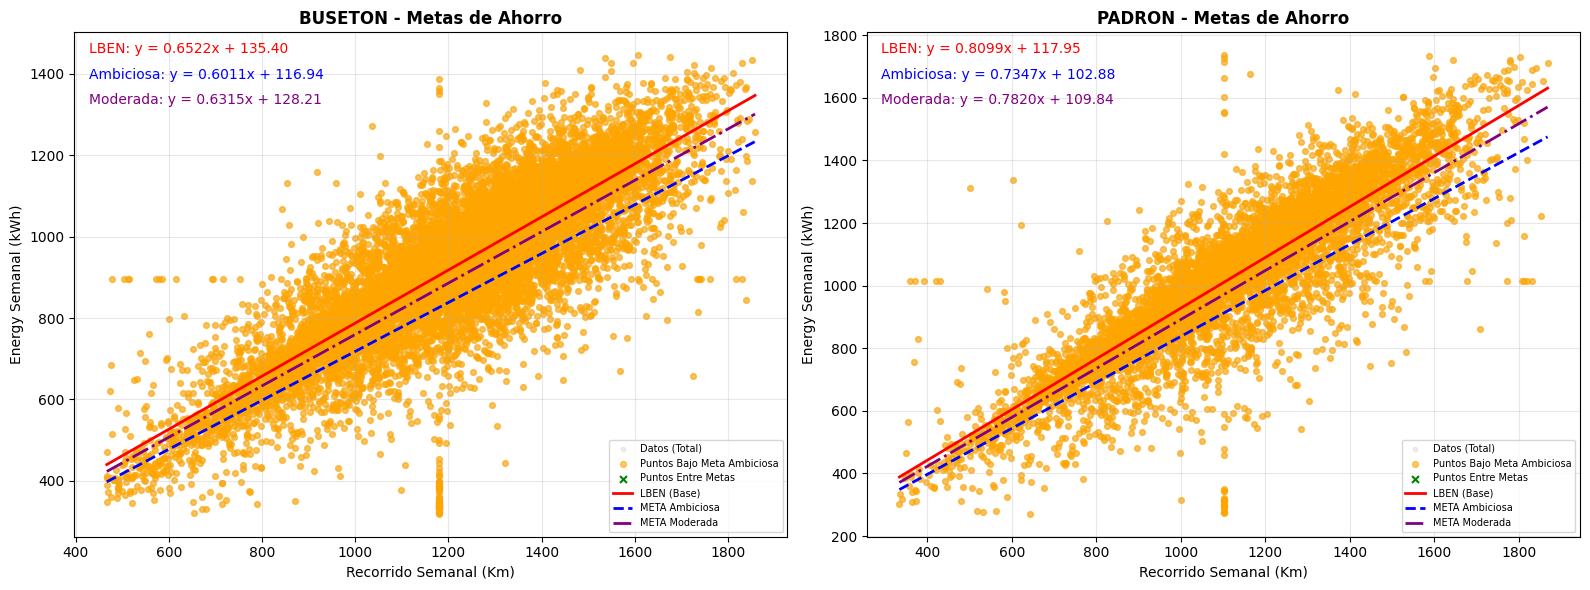


   - Gráfica Comparativa de Consumo y Ahorro Total (kWh) [Más Compacta]


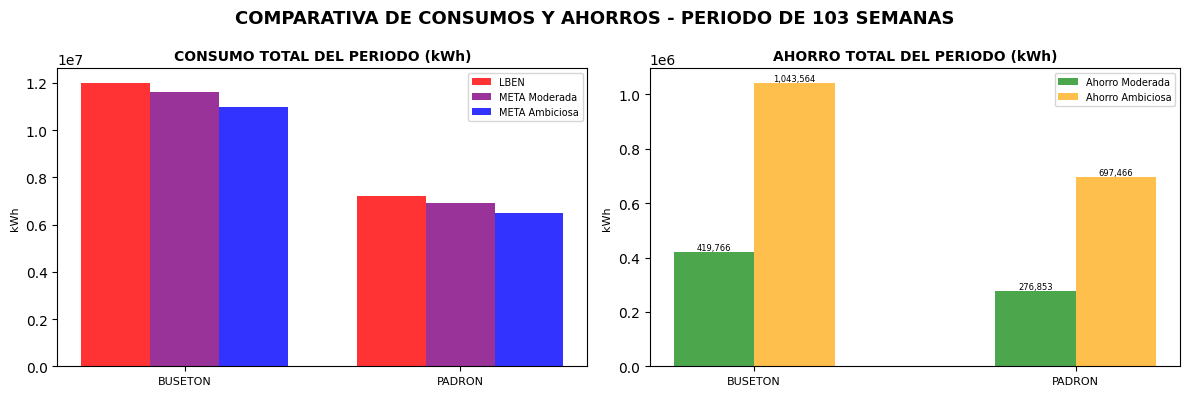


   - Gráfica de Porcentaje de Ahorro Total (%) [Más Compacta]


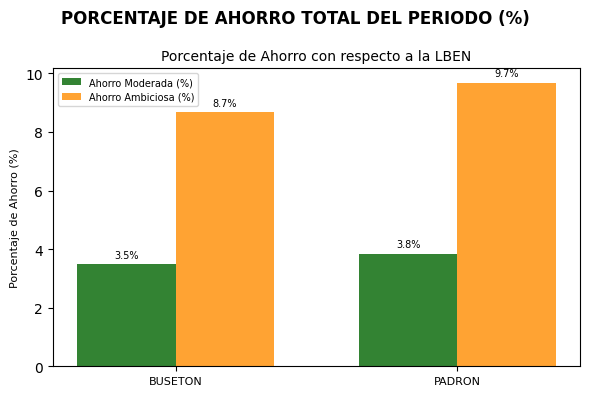


4. 💾 EXPORTANDO RESULTADOS A EXCEL

✅ Datos de metas exportados exitosamente a 'Metas_Ahorro_Vehiculos.xlsx'


In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl")

# ==============================================================================
# --- PREPARACIÓN INICIAL DE DATOS (Agrupación Semanal) ---
# ==============================================================================

# ⚠️ Nota: Esta parte debe ejecutarse en tu entorno para definir df_regresion_data
try:
    if 'FechaCarga' not in df_regresion_data.columns:
        raise ValueError("El DataFrame debe contener la columna 'FechaCarga'.")

    # 1. Convertir 'FechaCarga' a datetime 
    df_regresion_data['FechaCarga'] = pd.to_datetime(df_regresion_data['FechaCarga'])

    # 2. CREAR EL IDENTIFICADOR DE PERIODO SEMANAL (Necesario para contar semanas)
    df_regresion_data['Periodo_Semanal'] = df_regresion_data['FechaCarga'].dt.strftime('%Y-W%V')

    # Usamos Periodo_Semanal como la columna 'Periodo'
    df_regresion_data['Periodo'] = df_regresion_data['Periodo_Semanal'] 
    
    num_periodos = df_regresion_data['Periodo'].nunique()
    print(f"✅ Número total de periodos (SEMANAS) detectados: {num_periodos}")
    
except NameError:
    print("\n🚨 ERROR: La variable 'df_regresion_data' no está definida.")
    raise
except ValueError as e:
    print(f"\n🚨 ERROR en datos: {e}")
    raise


# ==============================================================================
# --- FUNCIONES DE BASE Y CÁLCULO (LBEN y Metas) ---
# ==============================================================================

def evaluar_modelo(modelo, df):
    if len(df) < 1: return {'R2': np.nan, 'MSE': np.nan, 'MAE': np.nan}
    X = df['Recorrido_Semanal'].values.reshape(-1, 1)
    y = df['Energy_Semanal'].values
    y_pred = modelo.predict(X)
    return {'R2': r2_score(y, y_pred), 'MSE': mean_squared_error(y, y_pred), 'MAE': mean_absolute_error(y, y_pred)}

def entrenar_modelos_lben(df_regresion_data):
    tipos_unicos = df_regresion_data['TIPO'].unique()
    dataframes_por_tipo = {tipo: df_regresion_data[df_regresion_data['TIPO'] == tipo].copy() for tipo in tipos_unicos}
    modelos = {}
    plots_data = {}
    for tipo, df_tipo in dataframes_por_tipo.items():
        if len(df_tipo) < 3: continue
        test_size_global = 0.10 if tipo == 'PADRON' else 0.20
        df_train, df_temp = train_test_split(df_tipo, test_size=test_size_global, random_state=42)
        X_train = df_train['Recorrido_Semanal'].values.reshape(-1, 1)
        y_train = df_train['Energy_Semanal'].values
        modelo = LinearRegression()
        modelo.fit(X_train, y_train)
        modelos[tipo] = modelo
        df_test, _ = train_test_split(df_temp, test_size=0.5, random_state=42)
        metricas_test = evaluar_modelo(modelo, df_test)
        plots_data[tipo] = {
            'df_train': df_train,
            'coef': modelo.coef_[0], 'intercept': modelo.intercept_, 'r2_test': metricas_test['R2']
        }
    return modelos, dataframes_por_tipo, plots_data

def construir_metas_semanales(df_tipo, model_lben, titulo="FLOTA"):
    df_clean = df_tipo.dropna(subset=['Recorrido_Semanal', 'Energy_Semanal']).copy()
    if len(df_clean) < 2: return None, None, None
    X = df_clean['Recorrido_Semanal'].values.reshape(-1, 1)
    y = df_clean['Energy_Semanal'].values
    preds_lben = model_lben.predict(X)
    
    # Meta Ambiciosa
    mask_amb = y < preds_lben
    X_amb, y_amb = X[mask_amb], y[mask_amb]
    model_amb = LinearRegression()
    if len(X_amb) > 1: model_amb.fit(X_amb, y_amb)
    else: model_amb.coef_ = model_lben.coef_; model_amb.intercept_ = model_lben.intercept_
    preds_amb = model_amb.predict(X)

    # Meta Moderada
    mask_mod = (y >= preds_amb) & (y <= preds_lben)
    X_mod, y_mod = X[mask_mod], y[mask_mod]
    model_mod = LinearRegression()
    if len(X_mod) > 1: model_mod.fit(X_mod, y_mod)
    else: 
        model_mod.coef_ = (model_amb.coef_ + model_lben.coef_) / 2
        model_mod.intercept_ = (model_amb.intercept_ + model_lben.intercept_) / 2
    preds_mod = model_mod.predict(X)

    ahorro_amb = np.maximum(preds_lben - preds_amb, 0)
    ahorro_mod = np.maximum(preds_lben - preds_mod, 0)
    n_periodos = df_clean['Periodo'].nunique()

    info = {
        'tipo': titulo,
        'LBEN_coef': float(model_lben.coef_[0]), 'LBEN_intercept': float(model_lben.intercept_),
        'AMB_coef': float(model_amb.coef_[0]), 'AMB_intercept': float(model_amb.intercept_),
        'MOD_coef': float(model_mod.coef_[0]), 'MOD_intercept': float(model_mod.intercept_),
        'total_LBEN_kWh_periodo': float(preds_lben.sum()),
        'total_AMB_kWh_periodo': float(preds_amb.sum()), 
        'total_MOD_kWh_periodo': float(preds_mod.sum()), 
        'ahorro_AMB_kWh_periodo': float(ahorro_amb.sum()),
        'ahorro_MOD_kWh_periodo': float(ahorro_mod.sum()),
        'n_total': len(y), 'n_periodos': n_periodos, 'n_vehiculos': df_clean['IdVehiculo'].nunique()
    }
    info['pct_ahorro_AMB'] = (info['ahorro_AMB_kWh_periodo'] / info['total_LBEN_kWh_periodo']) * 100
    info['pct_ahorro_MOD'] = (info['ahorro_MOD_kWh_periodo'] / info['total_LBEN_kWh_periodo']) * 100

    return info, model_amb, model_mod

def calcular_metas_individuales(df_semanal, model_lben, model_amb, model_mod):
    df = df_semanal.copy()
    km = df['Recorrido_Semanal'].values.reshape(-1, 1)
    df['LBEN_kWh'] = model_lben.predict(km)
    df['META_Ambiciosa_kWh'] = model_amb.predict(km)
    df['META_Moderada_kWh'] = model_mod.predict(km)
    df['Ahorro_Ambiciosa_kWh'] = np.maximum(df['LBEN_kWh'] - df['META_Ambiciosa_kWh'], 0)
    df['Ahorro_Moderada_kWh'] = np.maximum(df['LBEN_kWh'] - df['META_Moderada_kWh'], 0)
    df.rename(columns={'Energy_Semanal': 'KWh_Real_Semanal', 'Recorrido_Semanal': 'Km_Semanal'}, inplace=True)
    return df

# ==============================================================================
# --- FUNCIONES DE VISUALIZACIÓN (Gráficas Totales y Dispersión) ---
# ==============================================================================

def grafica_dispersion_metas(df_metas, info, ax, tipo_bus):
    """Genera la gráfica de dispersión con las tres líneas de regresión y sus 3 ecuaciones. AUMENTA TAMAÑO DE FUENTE."""
    X = df_metas['Km_Semanal'].values.reshape(-1,1)
    y = df_metas['KWh_Real_Semanal'].values
    x_min, x_max = X.min(), X.max()
    X_line = np.linspace(x_min, x_max, 200).reshape(-1,1)
    
    Y_lben = info['LBEN_intercept'] + info['LBEN_coef'] * X_line
    Y_amb = info['AMB_intercept'] + info['AMB_coef'] * X_line
    Y_mod = info['MOD_intercept'] + info['MOD_coef'] * X_line
    
    mask_amb = df_metas['Ahorro_Ambiciosa_kWh'] > 0
    mask_mod = (df_metas['Ahorro_Moderada_kWh'] > 0) & (df_metas['Ahorro_Ambiciosa_kWh'] == 0)

    # Scatter plots
    ax.scatter(X, y, color='lightgray', alpha=0.4, s=10, label='Datos (Total)')
    ax.scatter(X[mask_amb], y[mask_amb], color='orange', s=18, alpha=0.6, label='Puntos Bajo Meta Ambiciosa')
    ax.scatter(X[mask_mod], y[mask_mod], color='green', marker='x', s=25, label='Puntos Entre Metas')
    
    # Líneas de tendencia
    ax.plot(X_line, Y_lben, color='red', linewidth=2, label='LBEN (Base)')
    ax.plot(X_line, Y_amb, color='blue', linestyle='--', linewidth=2, label='META Ambiciosa')
    ax.plot(X_line, Y_mod, color='purple', linestyle='-.', linewidth=2, label='META Moderada')
    
    # Ecuaciones (AUMENTO TAMAÑO DE FUENTE a 10)
    ec_lben = f"LBEN: y = {info['LBEN_coef']:.4f}x + {info['LBEN_intercept']:.2f}"
    ec_amb = f"Ambiciosa: y = {info['AMB_coef']:.4f}x + {info['AMB_intercept']:.2f}"
    ec_mod = f"Moderada: y = {info['MOD_coef']:.4f}x + {info['MOD_intercept']:.2f}"
    
    ax.text(0.02, 0.98, ec_lben, transform=ax.transAxes, color='red', fontsize=10, verticalalignment='top')
    ax.text(0.02, 0.93, ec_amb, transform=ax.transAxes, color='blue', fontsize=10, verticalalignment='top')
    ax.text(0.02, 0.88, ec_mod, transform=ax.transAxes, color='purple', fontsize=10, verticalalignment='top')
    
    ax.set_title(f'{tipo_bus} - Metas de Ahorro', fontweight='bold', fontsize=12)
    ax.set_xlabel('Recorrido Semanal (Km)')
    ax.set_ylabel('Energy Semanal (kWh)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7)

def grafica_comparativa_totales(resultados_metas):
    """Genera la gráfica de barras comparando el Consumo y Ahorro Total del Periodo (más pequeña)."""
    tipos = list(resultados_metas.keys())
    datos = [resultados_metas[t] for t in tipos]
    if not datos: return

    n_periodos = datos[0]['n_periodos'] 

    # Tamaño aún más pequeño: (12, 4)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
    fig.suptitle(f'COMPARATIVA DE CONSUMOS Y AHORROS - PERIODO DE {n_periodos} SEMANAS', fontsize=13, fontweight='bold')
    
    # SUBGRÁFICA 1: Consumo Total del Periodo
    consumos_lben = [d['total_LBEN_kWh_periodo'] for d in datos]
    consumos_mod = [d['total_MOD_kWh_periodo'] for d in datos]
    consumos_amb = [d['total_AMB_kWh_periodo'] for d in datos]
    
    x_pos = np.arange(len(tipos))
    ancho = 0.25
    
    axes[0].bar(x_pos - ancho, consumos_lben, ancho, label='LBEN', color='red', alpha=0.8)
    axes[0].bar(x_pos, consumos_mod, ancho, label='META Moderada', color='purple', alpha=0.8)
    axes[0].bar(x_pos + ancho, consumos_amb, ancho, label='META Ambiciosa', color='blue', alpha=0.8)
    
    axes[0].set_title('CONSUMO TOTAL DEL PERIODO (kWh)', fontweight='bold', fontsize=10)
    axes[0].set_xticks(x_pos); axes[0].set_xticklabels(tipos, fontsize=8); axes[0].legend(fontsize=7)
    axes[0].set_ylabel('kWh', fontsize=8); axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
    
    # SUBGRÁFICA 2: Ahorro Total del Periodo
    ahorros_mod = [d['ahorro_MOD_kWh_periodo'] for d in datos]
    ahorros_amb = [d['ahorro_AMB_kWh_periodo'] for d in datos]
    
    axes[1].bar(x_pos - ancho/2, ahorros_mod, ancho, label='Ahorro Moderada', color='green', alpha=0.7)
    axes[1].bar(x_pos + ancho/2, ahorros_amb, ancho, label='Ahorro Ambiciosa', color='orange', alpha=0.7)
    
    axes[1].set_title('AHORRO TOTAL DEL PERIODO (kWh)', fontweight='bold', fontsize=10)
    axes[1].set_xticks(x_pos); axes[1].set_xticklabels(tipos, fontsize=8); axes[1].legend(fontsize=7)
    axes[1].set_ylabel('kWh', fontsize=8); axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
    
    # Etiquetas de valor
    for i in range(len(tipos)):
        axes[1].text(i - ancho/2, ahorros_mod[i], f'{ahorros_mod[i]:,.0f}', ha='center', va='bottom', fontsize=6)
        axes[1].text(i + ancho/2, ahorros_amb[i], f'{ahorros_amb[i]:,.0f}', ha='center', va='bottom', fontsize=6)
        
    plt.tight_layout(); plt.show()

def grafica_porcentaje_ahorro_total(resultados_metas):
    """Genera una gráfica de barras con el Porcentaje de Ahorro Total por tipo de bus (más pequeña)."""
    tipos = list(resultados_metas.keys())
    datos = [resultados_metas[t] for t in tipos]
    if not datos: return

    pct_amb = [d['pct_ahorro_AMB'] for d in datos]
    pct_mod = [d['pct_ahorro_MOD'] for d in datos]
    
    x_pos = np.arange(len(tipos))
    ancho = 0.35
    
    # Tamaño aún más pequeño: (6, 4)
    fig, ax = plt.subplots(figsize=(6, 4)) 
    fig.suptitle('PORCENTAJE DE AHORRO TOTAL DEL PERIODO (%)', fontsize=12, fontweight='bold')
    
    rects1 = ax.bar(x_pos - ancho/2, pct_mod, ancho, label='Ahorro Moderada (%)', color='darkgreen', alpha=0.8)
    rects2 = ax.bar(x_pos + ancho/2, pct_amb, ancho, label='Ahorro Ambiciosa (%)', color='darkorange', alpha=0.8)
    
    ax.set_title('Porcentaje de Ahorro con respecto a la LBEN', fontsize=10)
    ax.set_xticks(x_pos); ax.set_xticklabels(tipos, fontsize=8)
    ax.set_ylabel('Porcentaje de Ahorro (%)', fontsize=8)
    ax.legend(loc='upper left', fontsize=7)
    ax.set_ylim(bottom=0)

    # Agregar etiquetas de valor
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=7)

    autolabel(rects1)
    autolabel(rects2)
        
    plt.tight_layout(); plt.show()

# ==============================================================================
# --- FUNCIÓN DE EXPORTACIÓN A EXCEL ---
# ==============================================================================

def exportar_metas_a_excel(dataframes_metas, resultados_metas):
    if not dataframes_metas:
        print("⛔ No hay datos de metas para exportar.")
        return
        
    with pd.ExcelWriter('Metas_Ahorro_Vehiculos.xlsx', engine='openpyxl') as writer:
        ecuaciones_list = []
        
        for tipo, df_metas in dataframes_metas.items():
            
            info = resultados_metas[tipo]
            ecuaciones_list.append({
                'Tipo': tipo,
                'Periodos_Analizados (Semanas)': info['n_periodos'],
                'Registros_Totales': info['n_total'],
                'LBEN_Ecuacion': f"y = {info['LBEN_coef']:.4f}x + {info['LBEN_intercept']:.2f}",
                'AMB_Ecuacion': f"y = {info['AMB_coef']:.4f}x + {info['AMB_intercept']:.2f}",
                'MOD_Ecuacion': f"y = {info['MOD_coef']:.4f}x + {info['MOD_intercept']:.2f}",
                'Total_LBEN_kWh': info['total_LBEN_kWh_periodo'],
                'Total_Ahorro_Amb_kWh': info['ahorro_AMB_kWh_periodo'],
                'Total_Ahorro_Mod_kWh': info['ahorro_MOD_kWh_periodo'],
                'Pct_Ahorro_Ambiciosa': info['pct_ahorro_AMB'],
                'Pct_Ahorro_Moderada': info['pct_ahorro_MOD']
            })
            
            df_export = df_metas[['TIPO', 'IdVehiculo', 'Periodo', 'Km_Semanal', 'KWh_Real_Semanal', 
                                  'LBEN_kWh', 'META_Ambiciosa_kWh', 'META_Moderada_kWh', 
                                  'Ahorro_Ambiciosa_kWh', 'Ahorro_Moderada_kWh' ]].copy()
            df_export.to_excel(writer, sheet_name=f'{tipo}_Metas_Individuales', index=False)
            
            resumen_periodo = df_metas.groupby('Periodo').agg({'LBEN_kWh': 'sum', 'Ahorro_Ambiciosa_kWh': 'sum', 'Ahorro_Moderada_kWh': 'sum'}).reset_index()
            resumen_periodo['%_Ahorro_Ambiciosa'] = (resumen_periodo['Ahorro_Ambiciosa_kWh'] / resumen_periodo['LBEN_kWh']) * 100
            resumen_periodo['%_Ahorro_Moderada'] = (resumen_periodo['Ahorro_Moderada_kWh'] / resumen_periodo['LBEN_kWh']) * 100
            resumen_periodo.to_excel(writer, sheet_name=f'{tipo}_Resumen_Semanal', index=False)
            
        pd.DataFrame(ecuaciones_list).to_excel(writer, sheet_name='RESUMEN_TOTALES_AHORRO', index=False)

    print(f"\n✅ Datos de metas exportados exitosamente a 'Metas_Ahorro_Vehiculos.xlsx'")


# ==============================================================================
# --- EJECUCIÓN PRINCIPAL DEL PROCESO ---
# ==============================================================================

# 1. ENTRENAMIENTO DE MODELOS LBEN (BASE)
print("==============================================")
print("1. 🏃‍♂️ ENTRENAMIENTO DE MODELOS BASE (LBEN)")
print("==============================================")

modelos, dataframes_por_tipo, plots_data = entrenar_modelos_lben(df_regresion_data)

# 2. CÁLCULO DE METAS (AMBICIOSA Y MODERADA)
print("\n==============================================")
print("2. 🎯 CÁLCULO DE METAS DE AHORRO")
print("==============================================")

resultados_metas = {}
dataframes_metas = {}

for tipo, df_tipo in dataframes_por_tipo.items():
    if tipo in modelos:
        print(f"\n⚙️ Procesando Metas para Tipo: {tipo}")
        model_lben = modelos[tipo]
        
        info, model_amb, model_mod = construir_metas_semanales(df_tipo, model_lben, tipo)

        if info:
            resultados_metas[tipo] = info
            df_metas = calcular_metas_individuales(df_tipo, model_lben, model_amb, model_mod)
            dataframes_metas[tipo] = df_metas
            
            print(f"   📊 Ahorro Ambicioso Total: {info['ahorro_AMB_kWh_periodo']:,.0f} kWh")
            print(f"   📈 Porcentaje Ambicioso Total: {info['pct_ahorro_AMB']:.1f}%")


# 3. VISUALIZACIÓN DE RESULTADOS
if dataframes_metas:
    print("\n==============================================")
    print("3. 📈 GENERANDO GRÁFICAS DE RESULTADOS TOTALES")
    print("==============================================")
    
    print("\n   - Gráficas de Dispersión (LBEN vs Metas) con 3 Ecuaciones [Letra Grande]")
    n_tipos_metas = len(dataframes_metas)
    fig, axes = plt.subplots(1, n_tipos_metas, figsize=(8 * n_tipos_metas, 6))
    if n_tipos_metas == 1: axes = [axes]
    
    for i, (tipo, df_metas) in enumerate(dataframes_metas.items()):
        grafica_dispersion_metas(df_metas, resultados_metas[tipo], axes[i], tipo)
        
    plt.tight_layout(); plt.show()

    print("\n   - Gráfica Comparativa de Consumo y Ahorro Total (kWh) [Más Compacta]")
    grafica_comparativa_totales(resultados_metas)
    
    print("\n   - Gráfica de Porcentaje de Ahorro Total (%) [Más Compacta]")
    grafica_porcentaje_ahorro_total(resultados_metas)


# 4. EXPORTACIÓN A EXCEL
print("\n==============================================")
print("4. 💾 EXPORTANDO RESULTADOS A EXCEL")
print("==============================================")
exportar_metas_a_excel(dataframes_metas, resultados_metas)

Con base en el análisis de regresión y los resultados de eficiencia energética por tipo de vehículo, se ha determinado la Meta Moderada como el objetivo inicial de ahorro a implementar para la flota.

Esta decisión se fundamenta en que la Meta Moderada representa un objetivo de ahorro realista, alcanzable y sostenible a corto plazo, minimizando la resistencia operativa y maximizando la probabilidad de éxito en la fase inicial del programa.
